## Импорт библиотек

In [2]:
  # Библиотека с API для рекомендательных моделей
!pip install implicit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 18.6 MB 2.4 MB/s 


In [3]:
# Для обработки текста и лемматизации
!pip install pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 2.0 MB/s 
     |████████████████████████████████| 8.2 MB 4.3 MB/s 
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=1af4bf3de4dd097fab85a155bef7161872dbca13f8d87b72567cfd79fd454378
  Stored in directory: /root/.cache/pip/wheels/72/b0/3f/1d95f96ff986c7dfffe46ce2be4062f38ebd04b506c77c81b9
Successfully built docopt


In [4]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
import scipy.sparse as sparse
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

# Сохранение и загрузка моделей
import pickle

# Графики
import matplotlib.pyplot as plt
import seaborn as sns

# Библиотека для рекомендаций Implicit
from implicit.als import AlternatingLeastSquares
from implicit.bpr import BayesianPersonalizedRanking

# Векторизация текстов
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics.pairwise import cosine_similarity
import sklearn.preprocessing as pp

# Обработка текста и работа со словарями
import nltk
import pymorphy2
import requests


/usr/local/lib/python3.7/dist-packages/implicit/gpu/__init__.py:14: UserWarning: CUDA extension is built, but disabling GPU support because of 'Cuda Error: no CUDA-capable device is detected (/project/./implicit/gpu/utils.h:71)'
  f"CUDA extension is built, but disabling GPU support because of '{e}'",


In [5]:
nltk.download('stopwords')
from nltk.corpus import stopwords as nltk_stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
###############################################
# Исходные функции для модели с рекомендациями
##############################################

def contest_metric(df_solution, df_grd, print_report=True):

  """
  Возвращает метрики Recall, Precision, F1-score и количество угаданных книг  
  """

  pred = set(df_solution['chb'] + '_' + df_solution['sys_numb'].values)
  true = set(df_grd['chb'] + '_' + df_grd['sys_numb'].values) 
  recall = len(pred.intersection(true)) / len(true)
  precision = len(pred.intersection(true)) / (20 * len(df_grd['chb'].unique()))
  
  f1_score = 2 * (precision * recall) / (precision + recall)
  true_pairs_count = len(pred.intersection(true))

  if print_report == True:
    print(f"Угаданных книг: {true_pairs_count}")
    print(f"Recall: {round(recall, 5)}")
    print(f"Precision: {round(precision, 5)}")
    print(f"F1-score: {round(f1_score, 5)}")  

  return [true_pairs_count, recall, precision, f1_score]


def df_to_sparse(df, user_index_dict, item_index_dict):
  """
  Создает sparse-матрицу из датафрейма

  Данные о пользователях в столбце 'chb', данные о книгах - в столбце 'sys_numb`
  Внешние словари используются для получения ID каждого пользователя и книги
  """
  row = []
  col = []
  data = []

  for line in df.itertuples():
    row.append(user_index_dict[line.chb])
    col.append(item_index_dict[line.sys_numb])
    data.append(1)
  
  return csr_matrix((data, (row, col)))


##################################################################
# Подготовка данных для обучения
##################################################################

def recs_split_random(df, test_size):
  """
  Возвращает train и test, разделенные c помощью np.random
  """

  # Используем np.random для рандомизации индексов
  df['random'] = np.random.random(size=len(df))

  # Создаем маски индексов для train и test датасетов
  # test_size - размер валидационной выборки
  train_mask = df['random'] <  (1 - test_size)
  test_mask = df['random'] >= (1 - test_size)
  
  # Разделяем датасет на train и test, используя маски индексов
  train = df[train_mask]
  test = df[test_mask]
  return train, test


def split_and_prepare_recs_data(data, user_col, item_col, test_size,
                                weight_col='items', 
                                print_report=True,
                                delete_test_duplicates=True):
  
  """
  Разделяет на выборки, готовит данные для рекомендательных моделей 
  и выводит количество неизвестных user и item в тесте

  Возвращает train, test, полный датасет и веса
  Если в датасете только уникальные пары user-item, то все веса = 1
  """

  train_data, test_data = recs_split_random(data, test_size)
  all_data = data
  
  # Если создаем матрицу для implicit feedback (0, 1)
  if weight_col == 'items':
    # Отбираем столбцы с данными о пользователях и объектов рекомендации
    # Добавляем данные c частотой каждой пары user-item в поле 'items'
    train_data = (train_data.groupby([user_col, item_col])
                  .size()
                  .to_frame('items')
                  .reset_index())
    
    all_data = (data.groupby([user_col, item_col])
                  .size()
                  .to_frame('items')
                  .reset_index()) 
    
  # Удаляем дубликаты в тестовых данных
  if delete_test_duplicates == True:    
      test_data = (test_data.groupby([user_col, item_col])
                    .size()
                    .to_frame('items')
                    .reset_index())  

  # Нормализуем данные в поле weight_col
  # С параметром 'items' получим столбец из единиц
  train_weight = np.log2(train_data[weight_col] + 1)  
  all_weight = np.log2(all_data[weight_col] + 1)
 

  # Отдельные датасеты для пар user-item 
  train_data = train_data[[user_col, item_col]]
  test_data = test_data[[user_col, item_col]]
  all_data = all_data[[user_col, item_col]]

  # Cписки уникальных пользователей для train и test
  train_users = np.sort(train_data[user_col].unique())
  test_users = np.sort(test_data[user_col].unique())

  # Списки уникальных items для train и test
  train_items= np.sort(train_data[item_col].unique())
  test_items= np.sort(test_data[item_col].unique())

  # Новые users и items, незнакомые для модели
  # они не попадут в обучение
  cold_start_items = set(test_items) - set(train_items)
  cold_start_users = set(test_users) - set(train_users)

  if print_report:
    print("=> Количество пользователей")
    print(f"Общий датасет: {len(unique_transactions[user_col].unique())}")
    print(f"Обучающая выборка: {len(train_users)}")
    print(f"Валидационная выборка: {len(test_users)}")
    print()    
    print("=> Проблема cold start для модели")
    print("Неизвестных пользователей:", len(cold_start_users))
    print("Неизвестных объектов:", len(cold_start_items))
  
  # Набор датасетов для обучения рекомендательных моделей
  recs_datasets = {
      'train_user_item': train_data,
      'test_user_item': test_data,
      'all_user_item': all_data,
      'train_weight': train_weight,
      # 'test_weight': test_weight,
      'all_weight': all_weight
  }
  return recs_datasets

def get_user_item_matrix(user_items_df, user_col, item_col, 
                         user_item_weight_list):

  """Генерирует СSR-матрицу user-items в формате индексов для обучения моделей
  
  Возвращает:
  -------
  csr-матрица user-items с индексами
  словари для обратного перевода индексов user и item в исходные названия
  """
  
  # Cловари для маппинга индексов ID -> читатель/книга
  index_to_user = pd.Series(np.sort(np.unique(user_items_df[user_col])))
  index_to_item = pd.Series(np.sort(np.unique(user_items_df[item_col])))

  # Словари для обратного маппинга
  user_to_index = pd.Series(data=index_to_user.index, 
                            index=index_to_user.values)
  item_to_index = pd.Series(data=index_to_item.index, 
                            index=index_to_item.values)

  # Добавляем индексы в обучающий датасет
  user_items_df_indexed = user_items_df.copy()
  user_items_df_indexed['user_id'] = user_items_df[user_col].map(user_to_index)
  user_items_df_indexed['item_id'] = user_items_df[item_col].map(item_to_index)

  # Данные для перевода датасета в CSR матрицу
  data = user_item_weight_list
  rows = user_items_df_indexed['user_id']
  cols = user_items_df_indexed['item_id']

  # CSR матрица user(строки)-books(столбцы)
  user_items_csr = csr_matrix((data, (rows, cols)), 
                              shape=(len(user_to_index), len(item_to_index)))

  return user_items_csr, index_to_user, index_to_item


########################################################################
# Получение рекомендаций с помощью моделей implicit
########################################################################

def get_implicit_recommendations(trained_model_imp, user_items_matrix, 
                                 index_to_user_map, index_to_item_map, 
                                 top_n=20, filter_liked_items=True):  
  """
  Генерирует top_n рекомендаций с обученной моделью библиотеки implicit

  Возвращает:
  ----------
  Датафрейм, где каждая строка - список top_n рекомендаций для пользователя
  индексы - названия users, 
  данные - названия items из словарей index_to_user_map, index_to_item_map
  """

  # Получаем список рекомендаций - матрица с индексами книг и читателей
  recs_matrix = trained_model_imp.recommend_all(
      user_items=user_items_matrix, 
      N=top_n, 
      filter_already_liked_items=filter_liked_items
  )

  # Создаем датафрейм
  # Переводим индексы в исходные названия user и item
  recs_df = (
      pd.DataFrame(recs_matrix, index=index_to_user_map)
      .apply(lambda c: c.map(index_to_item_map))
  )

  return recs_df


def get_avg_recs_metrics(recs_matrix, valid_user_items_df,
                               user_col, item_col, 
                               print_report=True, round_n=4):
  """
  Считает и выводит усредненные метрики для матрицы рекомендаций

  Параметры:
  ---------
  recs_matrix - матрица предсказаний, строка = список рекомендаций для пользователя
  valid_user_items_df - валидационный датасет 
  """
  # Создаем словарь из валидационного датасета
  # ключ = user_name, значения = item_name
  user_items_dict = (
      valid_user_items_df
      .groupby(user_col)[item_col]
      .apply(set).to_dict()
  )
  
  # Ищем пересечение множества пользователей, на которых была обучена модель
  # с пользователями в валидационном датасете
  train_users = recs_matrix.index.to_list()
  valid_users = valid_user_items_df[user_col].unique()
  users_to_compare = set(train_users) & set(valid_users)

  # Считаем усредненные метрики по всем пользователям
  # hit-rate, precision, recall и f1-score
  hitrate = round(
      np.mean([int(len(set(recs_matrix.loc[u]) & user_items_dict[u]) > 0) for u in users_to_compare]), round_n)

  precision = round(
      np.mean([
      len(set(recs_matrix.loc[u]) & user_items_dict[u]) / 
      len(recs_matrix.loc[u]) for u in users_to_compare]), 5)

  recall = round(
      np.mean([
      len(set(recs_matrix.loc[u]) & user_items_dict[u]) / 
      len(user_items_dict[u]) for u in users_to_compare]), 5)

  f1_score = round(
      2 * (precision * recall) / (precision + recall), 5)


  if print_report:
    print(f"Hit-Rate_avg: {hitrate}")
    print(f"Recall_avg: {precision}")
    print(f"Precision_avg: {recall}")
    print(f"F1-score_avg: {f1_score}")
    
  return [hitrate, precision, recall, f1_score]


def matrix_recs_to_pairs(recs_matrix_df, 
                         user_col_name, item_col_name):
  """
  Переводит матрицу рекомендаций в датафрейм с парами user-item
  
  
  Параметры:
  --------
  recs_matrix_df - каждая строка [u]- список рекомендованных 
                   items для пользователя [u]  
  user_col_name - название столбца для user
  item_col_name - название столбца для item

  Возвращает датафрейм с двумя столбцами.
  """
  # Переводим 2D набор items в 1D список
  pairs_df= pd.DataFrame(recs_matrix_df.values.ravel(), 
                         columns=[item_col_name])
  
  # Количество столбцов = количество рекомендаций
  top_n = recs_matrix_df.shape[1]

  # Добавляем индексы пользователей по порядку
  # одинаковый индекс для каждых top_n строк
  pairs_df[user_col_name] = pairs_df.index  // top_n

  
  # Маппинг индексов в имена пользователей
  # используем матрицу рекомендаций 
  pairs_df[user_col_name] = pairs_df[user_col_name].map(
      (recs_matrix_df.reset_index()
       .rename(columns={'index':user_col_name})[user_col_name].to_dict())
  )

  return pairs_df



## Загрузка файлов

In [7]:
# Доступ к файлам на colab
import glob
import os

# Библиотека для работы с google drive
from google.colab import drive

# Монтируем диск
drive.mount('/content/drive')

# Смотрим файлы в директории
# !ls "/content/drive/My Drive/Colab Notebooks"

Mounted at /content/drive


In [8]:
# Меняем домашнюю директорию
# для доступа к датасетам
os.chdir("/content/drive/My Drive/Colab Notebooks")

In [9]:
# Cчитывание данных

# читатели
users = pd.read_csv(
    './users.csv', sep=';', index_col=None, 
     dtype={'age': str, 'chb': str, 'chit_type': str, 'gender': str})

# книги
items = pd.read_csv(
    'items.csv', sep=';', index_col=None, 
     dtype={'author': str, 'bbk': str, 'izd': str, 
           'sys_numb': str, 'title': str, 'year_izd': str})

# история книг в библиотеке
transactions = pd.read_csv(
    'train_transactions_extended.csv', 
    sep=';', index_col=None,
    dtype={'chb': str, 'date_1': str, 'is_printed': str, 
            'is_real': str, 'source': str, 'sys_numb': str, 'type': str})

## ЭТАП 5. Content Based Filtering для "неактивных" читателей

### (5.1) Вводные

#### Проблема "Cold Start"

1. Мы уже нашли книги, для которых не работает подход Collaborative Filtering

  - книги, которые прочитали всего `1 или 2 читателя`

2. Для остальных книг мы получили более высокие результаты:

  -  HitRate ~15%
  -  в 8 раз выше, чем на "редких" книгах

Посмотрим, какие пользователи не попали в датасет с "популярными" книгами!


In [21]:
unique_transactions = transactions[['chb', 'sys_numb']].drop_duplicates()

# Создаем новый датафрейм с количеством  читателей
# для каждой книги
books_popularity = (
    unique_transactions
    .groupby('sys_numb')
    .chb.count().to_frame()
    .rename(columns={'chb':'users_count'}))

# Создаем новый датафрейм с активностью пользователей
user_books_count = (
     unique_transactions.groupby('chb')
    .count().rename(columns={'sys_numb':'books_count'}))

In [10]:
# Оставляем книги с количеством читателей > 2
hot_start_dataset = (unique_transactions
                      .loc[lambda x: x.sys_numb.isin(
                          books_popularity.query('users_count > 2').index)]
                    )

In [11]:
# Книги и пользователи, которые не вошли в новый датасет
cold_start_books = (
  set(unique_transactions.sys_numb.unique()) - set(hot_start_dataset.sys_numb.unique())
)

cold_start_users = (
  set(unique_transactions.chb.unique()) - set(hot_start_dataset.chb.unique())
)


print("Читатели:", unique_transactions.chb.nunique())
print("Книги, которые читают:", unique_transactions.sys_numb.nunique())
print("------------------------------------------------------------------------")
print("==> Пользователи, для которых не работает CF (проблема Cold Start) <==\n")
print("Редких книг:", len(cold_start_books))
print("Читателей:", len(cold_start_users))
print("Количество книг, которые читают:\n")
display(user_books_count[user_books_count.index.isin(
          cold_start_users
          )].books_count.describe())

Читатели: 16753
Книги, которые читают: 194666
------------------------------------------------------------------------
==> Пользователи, для которых не работает CF (проблема Cold Start) <==

Редких книг: 188853
Читателей: 9071
Количество книг, которые читают:



count    9071.000000
mean        6.525962
std         8.971851
min         2.000000
25%         3.000000
50%         4.000000
75%         7.000000
max       495.000000
Name: books_count, dtype: float64

- Интересно, у нас также "отпали" пользователи, которые читают больше 7 книг и даже 400!

**Вывод**

1. Collaborative Filtering может работать для "зеленых" пользователей (c историей из 1-3 книг)

  - Если эти книги популярны среди других читателей =)

2. Collaborative Filtering может оказаться бесполезным для "активных" пользователей:

  - Если они читают очень редкие книги, которые не успели заинтересовать других пользователей)

3. Таких читателей сейчас > 50%, а "редких" книг - 97%!



- 

#### Решение

Попробуем использовать автоматический поиск **похожих** книг. 
Можем протестировать два подхода:


1. Метод `Content Based Filtering` для рекомендации набора похожих книг:

  - здесь нам не нужны рейтинги и интересы других пользователей)

2. Поиск "единомышленников" по книгам, которые похожи на текущие книги читателя.

  - возможно, они не читали Таню Гроттер, но читали "Узника Азкабана":)
  - такой подход даст большее разнообразие рекомендаций

3. Порекомендовать самые популярные книги из похожих жанров:)

Это будет альтернативой моделям `Collaborative Filtering`:
- даст возможность в итоге собрать **гибридную** рекомендательную систему.
- использовать различные подходы к персональным рекомендациям.



### (5.2) Оценка данных и план работы

#### Добавляем данные о книгах

Добавим в обучающий датасет с тарнзациями интересную инофрмацию о книгах:
- описание
- авторы
- год издания
- bbk (здесь, возможно, кроется информация о жанрах)


In [12]:
bk_transactions = (
    transactions[['chb', 'sys_numb']].drop_duplicates()
    .set_index('sys_numb')
    .join(items.set_index('sys_numb').drop('izd', axis=1))
    .reset_index()
)

bk_transactions.head(5)

,sys_numb,chb,title,author,year_izd,bbk
0,RSL01000000123,100000934918,"Антропонимы в киргизском героическом эпосе ""Ма...","Боронов, Адина Айылчиевич",1988,"Ш3(257=Ки)-611,0\nШ163.25-314,0"
1,RSL01000000244,300001043470,Chlorella pyrenoidosa 82Т как тест-объект в би...,"Дедов, Александр Викторович",1998,"Е591.21с,0"
2,RSL01000000259,300001090044,Айседора Дункан и театральная культура эпохи М...,"Добротворская, Карина Анатольевна",1992,"Щ327.75(7США)-86ДунканА.0,0"
3,RSL01000000457,100000728030,"""Записки"" А. И. Кошелева как памятник отечеств...","Летягин, Лев Николаевич",1993,"Ш5(2=Р)52-4КошелевА.И.534,0"
4,RSL01000000462,200001091160,Аграрная буржуазия в политической жизни Индии ...,"Литвин, Алексей Васильевич",1990,"Т3(5Ид)63-283,02\nТ3(5Ид)63-5,02"


#### Коды bbk и жанры

Посмотрим, насколько информативен новый датасет. Важнее всего поле bbk - жанр!

In [13]:
bk_transactions.isna().sum()

sys_numb     0
chb          0
title        0
author       0
year_izd     1
bbk         49
dtype: int64

Всего 50 пропусков..Слишком хорошо, чтобы быть правдой) Проверим!

In [14]:
bk_transactions.bbk.value_counts()

none                          67832
отсутствует                   17267
Щ158.9открытки3(2Р=Р)53-3       721
Ш5(2=Р)75-644.6                 721
Ю949.2,0                        474
                              ...  
Ю959.2,0\nЦ4,8(2)301.1            1
В1р(2)3-3,0                       1
Х620.612.299(2Р547)я431(2)        1
З973.2-018ц2я73-1                 1
Р62-433.77,0                      1
Name: bbk, Length: 79099, dtype: int64

Вот и загвоздка, 80 000 книг без жанров:/ Посмотрим, сколько книг останется для рекомендаций

In [15]:
print("Книги с bbk в датасете с транзакциями:",
bk_transactions.query('bbk != "none" and bbk!= "отсутствует"').sys_numb.nunique())

Книги с bbk в датасете с транзакциями: 119805


In [16]:
print("Книги с bbk в общей библиотеке:",
items[~items.bbk.isna()].query(
    'bbk != "none" and bbk!= "отсутствует"').sys_numb.nunique())

Книги с bbk в общей библиотеке: 215783


**Вывод 1**

1. У нас неполный набор данных о книгах, которые (!) уже читали:
  - 119 805 книг без пропусков в bbk

2. "+" ~100 000 книг с данными о bbk в общей библиотеке

2. Если удастся раскодировать bbk, то мы сможем рекомендовать не только похожие книги одного и того же автора (или сборника), но и что-то новенькое))

Прежде чем переходить к парсингу `bbk`, посмотрим, есть ли у нас уже книги с общим кодом?

In [17]:
# Количество книг с одинаковым bbk
(bk_transactions
 .query('bbk != "none" and bbk!= "отсутствует"')
 .bbk.value_counts().head(30))

Щ158.9открытки3(2Р=Р)53-3                                     721
Ш5(2=Р)75-644.6                                               721
Ю949.2,0                                                      474
Ш5(2=Р)75-644                                                 226
Э391.9,0                                                      223
Э240.03,0                                                     211
Ш5(2=Р)64-644.6                                               206
Э391.211,0                                                    202
Ш5(2=Р)64-644                                                 190
Ш5(2=Р)75-65я44                                               166
Х0я73-1                                                       165
Р120.4я9                                                      158
Щ156.658.3(2)53                                               148
Э391.215,0                                                    138
С556.511,0                                                    137
Х623я73-1 

**Вывод 2**

1. Из bbk мы можем узнать о жанре каждой книги:

  - распрасить, например, Ш5 = Мировая Литература, (2=Р) - Румынская литература
  - скачать БД со всеми кодами и доп.информацией

2. На первом этапе попробуем группировать книги по полному bbk без парсинга

#### Авторы

Авторов мы уже изучали, даже построили CF модель для рекомендации новых писателей

In [18]:
print("Количество книг каждого автора в активном пуле:")
(bk_transactions
 .query('bbk != "none" and bbk!= "отсутствует"')
 .author.value_counts().head(30))

Количество книг каждого автора в активном пуле:


none                                        31012
Конволют                                      308
Зверев, Сергей Иванович 1964-                 164
Струнников, Сергей Николаевич 1907-1944       120
Серова, Марина Сергеевна                       94
Нащокина, Мария Владимировна                   76
Москва, город                                  51
Нестеров, Михаил Петрович 1959-                50
Российская Федерация Законы                    46
Юнг, Карл Густав 1875-1961                     43
Романюк, Сергей Константинович                 41
Шахов, Максим Анатольевич 1964-                39
Фрейд, Зигмунд 1856-1939                       38
Устинова, Татьяна Витальевна 1968-             37
Алексеев, Сергей Сергеевич 1924-2013           37
По, Айрэн                                      35
Вострышев, Михаил Иванович                     34
Аристотель 384-322 до н. э.                    34
Сарабьянов, Дмитрий Владимирович               34
Широкорад, Александр Борисович                 34


In [19]:
print("Количество различных авторов для каждого bbk ")
bk_transactions.groupby('bbk').author.nunique().sort_values().tail(30)

Количество различных авторов для каждого bbk 


bbk
Ю953,0                48
Р358.9я9              49
Ю96,0                 52
Ш141.2-916.3,0        52
Х916.8,0              54
Х620.612.2,0          56
Ю949.2с,0             57
Х623.1,0              59
Х622.2,0              60
Х628.111.2,0          60
Ш5(2=Р)64-644.6       61
С508,0                63
Ю948.1-82,0           64
У9(2)29,0             69
Ш5(2=Р)75-6я44        76
Ш5(2=Р)64-65я44       80
Э391.215,0            84
Ш5(2=Р)64-644.5       89
С555.511,0            90
С556.511,0           105
Э240.03,0            121
Р120.4я9             124
Ш5(2=Р)75-65я44      128
Э391.211,0           129
Э391.9,0             141
Ш5(2=Р)64-644        144
Ш5(2=Р)75-644.6      174
Ш5(2=Р)75-644        178
Ю949.2,0             268
none               40383
Name: author, dtype: int64

In [20]:
print("Пример книг и кодов bbk для Конволют")

bk_transactions.query(
  'author == "Конволют"'
)

Пример книг и кодов bbk для Конволют


,sys_numb,chb,title,author,year_izd,bbk
4417,RSL01000572717,300000800833,Население России … : … ежегодный демографическ...,Конволют,1998,"С73(2)7,0"
13235,RSL01000860818,200001141982,Население России … : … ежегодный демографическ...,Конволют,1999,"С73(2)7,0"
14024,RSL01000949168,200001112107,: Roseum memoriale divinorum eloquiorum,Конволют,1493,none
14025,RSL01000949168,300000992541,: Roseum memoriale divinorum eloquiorum,Конволют,1493,none
16594,RSL01001228080,200000986599,Общее и прикладное языкознание : указ. литерат...,Конволют,1984,none
...,...,...,...,...,...,...
211875,RSL01011011478,200001057702,Справочник секретаря и офис-менеджера : практи...,Конволют,2022,none
211876,RSL01011011478,300001127269,Справочник секретаря и офис-менеджера : практи...,Конволют,2022,none
211884,RSL01011013848,300001093275,Вестник Томского государственного архитектурно...,Конволют,2022,none
211885,RSL01011014475,100001155175,GQ Style : журнал : Выпуски за 2022 год : 2022...,Конволют,2022,none


**Вывод**

1. Добавление авторов в модель:

  - Можем получить более высокие результаты предсказаний, т.к. многие берут книги из одного сборника или серии

  - Такие рекомендации менее интересны читателям 

  - В авторах у нас дополнительно еще 30 000 пропусков


3. Сфокусируемся вначале только на жанрах:

  - каждому bbk может соответствовать группа авторов
  
  - новые книги и авторы из похожих жанров должны сильнее заинтересовать читателей:)

#### Общий вывод

1. На первом этапе мы берем только книги **из "общего" пула** с транзакциями.

2. Первую модель построим на варианте с `bbk` и `годами выпуска`, далее можно добавить:

  - жанры из парсинга bbk

  - леммы из названий книг (тоже интересный вариант)

  - авторов (вдруг для читателя все-таки найдется самое подходящее для него произведение)

3. **Cкомбинируем** полученные рекомендации с рекомендациями из Collaborative Filtering.

### (5.3) Предобработка данных

#### Общие идеи

In [21]:
bk_transactions.query('bbk == "отсутствует"')

,sys_numb,chb,title,author,year_izd,bbk
3687,RSL01000344287,300000945480,отсутствует,отсутствует,отсутствует,отсутствует
5100,RSL01000589118,300000907376,отсутствует,отсутствует,отсутствует,отсутствует
5102,RSL01000589137,200000937642,отсутствует,отсутствует,отсутствует,отсутствует
5103,RSL01000589137,300000907376,отсутствует,отсутствует,отсутствует,отсутствует
11462,RSL01000728814,200001046353,отсутствует,отсутствует,отсутствует,отсутствует
...,...,...,...,...,...,...
228997,RSL60000347951,300000807978,отсутствует,отсутствует,отсутствует,отсутствует
228998,RSL60000347953,300000807978,отсутствует,отсутствует,отсутствует,отсутствует
228999,RSL60000349894,200000844116,отсутствует,отсутствует,отсутствует,отсутствует
229000,RSL60000349906,200000844116,отсутствует,отсутствует,отсутствует,отсутствует


- 20 000 книг с "отсутсвует" точно удалим из обучения, не раздумывая

- Было бы неплохо уточнить, возможно, где-то ошибка в БД

In [22]:
bk_transactions.query('bbk == "none"')

,sys_numb,chb,title,author,year_izd,bbk
387,RSL01000080370,300001102845,Московские частные художественные студии как я...,"Абаренкова, Елена Валерьевна",1996,none
488,RSL01000100670,300001116148,Формирование познавательного интереса у учащих...,"Кухарь, Алевтина Васильевна",1984,none
740,RSL01000143939,200000955424,Обоснование оптимальных параметров основных эл...,"Смирнов, Николай Григорьевич",1996,none
742,RSL01000144642,300000906881,Формирование ценностных ориентаций старшекласс...,"Анисимова, Татьяна Семеновна",Б. г.,none
746,RSL01000145484,300001129283,Формирование культуры речи у студентов педагог...,"Григорьева, Виктория Аркадьевна",1996,none
...,...,...,...,...,...,...
211948,RSL01011034405,200000955709,Отчет Государственного контроля по исполнению ...,none,СПб 1883,none
211949,RSL01011035001,300000935124,Опыт работы Государственной Публичной библиоте...,none,1954,none
211950,RSL01011035222,200000921337,Compte Rendu of the XV Session South-Africa 19...,none,Pretoria 1930,none
211951,RSL01011035900,100001083391,"Сборник ВИЗР,вып.4-5",none,"Ленинград,1932-1933",none


- Для первого этапа "none" удалим, а дальше (если будем строить модель и на других признаках), оставим эти книги

In [23]:
df_ML = bk_transactions[['chb', 'sys_numb', 'bbk', 'title', 'year_izd', 'author']].copy()
# .query('bbk != "none" and bbk!= "отсутствует"').copy()

df_ML['bbk'] = df_ML['bbk'].replace("none", "unknown")
df_ML['bbk'] = df_ML['bbk'].replace("отсутствует", "unknown")
df_ML['bbk'] = df_ML['bbk'].fillna("unknown")


print("Новый датасет для Content-Based рекомендаций")
print("Количество читателей:", df_ML.chb.nunique())
print("Количество книг:", df_ML.sys_numb.nunique())
print("Количество пропусков:")

df_ML.isna().sum()

Новый датасет для Content-Based рекомендаций
Количество читателей: 16753
Количество книг: 194666
Количество пропусков:


chb         0
sys_numb    0
bbk         0
title       0
year_izd    1
author      0
dtype: int64

- Для всех пользователей найдутся рекомендации))


In [24]:
df_ML.dtypes

chb         object
sys_numb    object
bbk         object
title       object
year_izd    object
author      object
dtype: object

**Вывод**

1. Все поля нужно будет закодировать до обучения:

  - Для sys_numb и chb у нас уже есть готовый подход

  - bbk можно закодировать произвольным образом

  - Год издания `year_izd` перевести в целый тип

  - Поле `title` перевести в набор слов одного регистра

2. Книги с bbk='отсутствуют' не имеют описаний и авторов (~20 000):

  - еще 67 000 c bbk='none' мы удалили только для первого этапа обучения.

#### Год издания

In [25]:
df_ML['year_izd'].value_counts().sort_values()

Ленинград,1932-1933        1
[185-]                     1
сор. 2011                  1
И. П. Цыбулько             1
печ. 1971                  1
                       ...  
2008                    8007
2020                    8048
2017                    8273
2016                   10217
отсутствует            17267
Name: year_izd, Length: 1795, dtype: int64

- Пока мы не можем перевести год выпуска в целый тип

- Попробуем отсечь 4 цифры с помощью регулярных выражений (одного года нам будет достаточно)

In [26]:
df_ML['year_2'] = df_ML['year_izd'].str.extract(r'(\d{4})')
df_ML['year_2'].value_counts().sort_values()

1724        1
1538        1
1738        1
1705        1
1759        1
        ...  
2019     7845
2008     8066
2020     8581
2017     8803
2016    10761
Name: year_2, Length: 336, dtype: int64

- Выглядит неплохо!

- Проверим, не осталось ли некорректных данных

In [27]:
df_ML['year_2'].isna().sum()

20035

In [28]:
print("Пропуски в годе издания книги:")
df_ML[df_ML.year_2.isna()]

Пропуски в годе издания книги:


,chb,sys_numb,bbk,title,year_izd,author,year_2
742,300000906881,RSL01000144642,unknown,Формирование ценностных ориентаций старшекласс...,Б. г.,"Анисимова, Татьяна Семеновна",NaN
775,200001103737,RSL01000152245,"Х623.213.1,0",Проблемы становления и перспективы развития ин...,Б. г.,"Шичанин, Алексей Викторович",NaN
811,300001064485,RSL01000157291,"Ш5(2=Р)53-4Чехов А.П.54,0",Проблема женских характеров в рассказах А. П. ...,Б. г.,"Лукьянова, Людмила Владимировна",NaN
815,300000842297,RSL01000157983,"У9(2)321.4,0",Развитие фермерских хозяйств в условиях перехо...,Б. г.,"Серов, Вячеслав Михайлович",NaN
1024,200001126554,RSL01000187571,unknown,Метод создания и реализации графического интер...,Б. г.,"Ле, Куок Лонг",NaN
...,...,...,...,...,...,...,...
228997,300000807978,RSL60000347951,unknown,отсутствует,отсутствует,отсутствует,NaN
228998,300000807978,RSL60000347953,unknown,отсутствует,отсутствует,отсутствует,NaN
228999,200000844116,RSL60000349894,unknown,отсутствует,отсутствует,отсутствует,NaN
229000,200000844116,RSL60000349906,unknown,отсутствует,отсутствует,отсутствует,NaN


- Книг без года издания достаточно много, не будем их удалять - похоже, это все ХХ век (или раньше)


In [29]:
df_ML.year_2.fillna('1900').astype('int').describe()

count    229002.000000
mean       1985.647549
std          46.010723
min        1092.000000
25%        1977.000000
50%        2006.000000
75%        2015.000000
max        5771.000000
Name: year_2, dtype: float64

- Есть еще загадочный год 5771..

- Большая часть - современные издания (но год написания может быть другой!)

In [30]:
df_ML['year_2'] = df_ML['year_2'].fillna('1900').astype('int')

print("Книги, датируемые позже 2022 года")
df_ML[df_ML['year_2'] > 2022]

Книги, датируемые позже 2022 года


,chb,sys_numb,bbk,title,year_izd,author,year_2
45305,200001132993,RSL01002756569,"Т3(532-2Хеврон)0,02",Кирьят Арба - Хеврон - город древний и молодой...,5761 (2001),none,5761
103065,300001124676,RSL01004976545,"Э36-210.91,0",Тора из Цийона. Пятикнижие Моше. Книга Бамидба...,5771 [2011],Тора,5771
163692,200001026068,RSL01008788263,"Е088в.я9\nЮ252:Е022,0",Биофилия. Врожденная тяга к живому как связь ч...,2117 (cop. 2016),"Уилсон, Эдвард Осборн 1929-",2117


- Интересная подборка))

- 5 книг пророка Моисея (Пятикнижие Моше)! Случайности не случайны)

Сделаем обычную замену

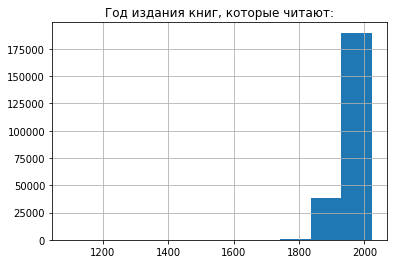

In [31]:
df_ML['year_2'] = df_ML['year_2'].replace({5761:2001, 5771:2011, 2117:2016})
df_ML.year_2.hist()
plt.title("Год издания книг, которые читают:")
plt.show()

**Вывод**

1. Мы скорректировали год издания у книг, теперь можно использовать это поле в моделях

2. Большинство книг, которые читают, имеют современное издание

  - это снижает ценность этого признака в предсказаниях:)

#### Авторы



In [32]:
print("Количество уникальных авторов в транзакциях:", df_ML.author.nunique())

Количество уникальных авторов в транзакциях: 104748


In [33]:
df_ML.author

0                 Боронов, Адина Айылчиевич
1               Дедов, Александр Викторович
2         Добротворская, Карина Анатольевна
3                   Летягин, Лев Николаевич
4                Литвин, Алексей Васильевич
                        ...                
228997                          отсутствует
228998                          отсутствует
228999                          отсутствует
229000                          отсутствует
229001                          отсутствует
Name: author, Length: 229002, dtype: object

**Вывод 1**

1. Авторы хорошо и корректно добавлены в БД..кроме Алексея Сергеевича с 1956 г.

2. Для поиска похожих книг нам нужно будет закодировать все 71031 варианта:

  - Попробуем использовать TF-IDF, возможно, он сократит нам набор признаков?

  - Такая гипотеза, т.к. у многих есть похожие имена и даже фамилии

Переведем авторов в список слов, разделенных одним пробелом - для TF-IDF.

In [34]:
# Убираем запятые между именем и фамилией
# и все случайные посторонние символы
df_ML['author_ml'] = df_ML['author'].str.replace("[^A-Яа-яA-Za-zё ]", "", regex=True)

df_ML[['author', 'author_ml']]

,author,author_ml
0,"Боронов, Адина Айылчиевич",Боронов Адина Айылчиевич
1,"Дедов, Александр Викторович",Дедов Александр Викторович
2,"Добротворская, Карина Анатольевна",Добротворская Карина Анатольевна
3,"Летягин, Лев Николаевич",Летягин Лев Николаевич
4,"Литвин, Алексей Васильевич",Литвин Алексей Васильевич
...,...,...
228997,отсутствует,отсутствует
228998,отсутствует,отсутствует
228999,отсутствует,отсутствует
229000,отсутствует,отсутствует


Отлично!

- Получили чистый набор из имен и фамилий

- 1956 год также нас покинул

Теперь можно применить TF-IDF

In [35]:
tfidf_vectorizer = TfidfVectorizer()
tfidf =  tfidf_vectorizer.fit_transform(df_ML['author_ml'])
tfidf

<229002x63734 sparse matrix of type '<class 'numpy.float64'>'
	with 545329 stored elements in Compressed Sparse Row format>

- Супер! Сократили набор авторов почти в два раза! Магия математики)

- Посмотрим, как

In [36]:
tfidf_vectorizer.vocabulary_

{'боронов': 8381,
 'адина': 1905,
 'айылчиевич': 2241,
 'дедов': 16655,
 'александр': 2533,
 'викторович': 11054,
 'добротворская': 17877,
 'карина': 24345,
 'анатольевна': 3299,
 'летягин': 30693,
 'лев': 30224,
 'николаевич': 38190,
 'литвин': 31055,
 'алексей': 2580,
 'васильевич': 10260,
 'лукомская': 31634,
 'марина': 33259,
 'иосифовна': 22686,
 'михайлова': 35377,
 'мария': 33294,
 'германовна': 13621,
 'петросянц': 41213,
 'виктор': 11043,
 'завенович': 20427,
 'попова': 42436,
 'константиновна': 26994,
 'русина': 45924,
 'юлия': 62898,
 'симонова': 48594,
 'эмилия': 62408,
 'станиславовна': 50141,
 'хабибуллина': 56122,
 'лилия': 30840,
 'фуатовна': 56002,
 'унарокова': 54221,
 'мира': 35101,
 'юнусовна': 62958,
 'красненко': 28020,
 'николай': 38200,
 'петрович': 41187,
 'крот': 28411,
 'михайлович': 35379,
 'манин': 33036,
 'виталий': 11301,
 'серафимович': 48159,
 'позднякова': 42047,
 'лариса': 30054,
 'бакер': 5494,
 'неман': 37793,
 'абдалла': 1036,
 'морозов': 35915,
 '

- 30 000 авторов с фамилией Овезгельдыевич..ухх

- видим, что TF-IDF vectorizer сам перевел имена и фамилии в нижний регистр

**Вывод**

1. Мы почистили названия авторов от дополнительных символов

2. С помощью TF-IDF Vectorizer и комбинирования популярных имен и фамилий:

  - сократили набор признаков для обучения в 2 раза

  - 47087 признаов вместо 71031 исходных названий авторов

3. Протестировали подход для датасета с транзакциями:
 - такую предобработку можно будет сделать для всего датасета с книгами `items`

#### Названия книг

##### Базовая предобработка 

На первом этапе мы не будем использовать названия, но дальше их обязательно добавим.

Поэтому сделаем сразу базовую предобработку текста, чтобы потом генерировать идеи)

In [37]:
df_ML.title.to_list()[0: 10]

['Антропонимы в киргизском героическом эпосе "Манас" : автореферат дис.. кандидата филологических наук : 10.02.06',
 'Chlorella pyrenoidosa 82Т как тест-объект в биологических испытаниях : автореферат дис.. кандидата биологических наук : 03.00.12',
 'Айседора Дункан и театральная культура эпохи Модерна : автореферат дис.. кандидата искусствоведения : 17.00.01',
 '"Записки" А. И. Кошелева как памятник отечественной мемуарной литературы : автореферат дис.. кандидата филологических наук : 10.01.01',
 'Аграрная буржуазия в политической жизни Индии : автореферат дис.. кандидата истор. наук : 07.00.03',
 'Алкоголизм в общемедицинской сети : (Выявление, типология, лечебно-профилактические программы) : автореферат дис.. доктора медицинских наук : 14.00.45,14.00.18',
 'Античность в русской литературе конца XVIII-начала XIX века : автореферат дис.. кандидата филологических наук : 10.01.10',
 'Адаптация государственного регулирования социально-экономического развития субъекта федерации к становле

- Бешеная смесь! Все названия длинные, а если их сложить вместе, можно написать целую книгу)

- Первым шагом переведем все названия в нижний регистр




In [38]:
# Переводим текст в нижний регистр
df_ML['title_clear'] = df_ML['title'].str.lower()
df_ML.title_clear.to_list()[0: 3]

['антропонимы в киргизском героическом эпосе "манас" : автореферат дис.. кандидата филологических наук : 10.02.06',
 'chlorella pyrenoidosa 82т как тест-объект в биологических испытаниях : автореферат дис.. кандидата биологических наук : 03.00.12',
 'айседора дункан и театральная культура эпохи модерна : автореферат дис.. кандидата искусствоведения : 17.00.01']

- Теперь удалим все дополнительные символы  и цифры в текстах

In [39]:
# Удаляем все символы, кроме русских и английских букв
# Букву ё нужно добавлять отдельно
df_ML['title_clear'] = df_ML['title_clear'].str.replace("[^а-яa-zё ]", "", regex=True)

# Смотрим результат
df_ML.title_clear.to_list()[0: 7]

['антропонимы в киргизском героическом эпосе манас  автореферат дис кандидата филологических наук  ',
 'chlorella pyrenoidosa т как тестобъект в биологических испытаниях  автореферат дис кандидата биологических наук  ',
 'айседора дункан и театральная культура эпохи модерна  автореферат дис кандидата искусствоведения  ',
 'записки а и кошелева как памятник отечественной мемуарной литературы  автореферат дис кандидата филологических наук  ',
 'аграрная буржуазия в политической жизни индии  автореферат дис кандидата истор наук  ',
 'алкоголизм в общемедицинской сети  выявление типология лечебнопрофилактические программы  автореферат дис доктора медицинских наук  ',
 'античность в русской литературе конца xviiiначала xix века  автореферат дис кандидата филологических наук  ']

- Красота, остались только слова и пробелы)

- Есть названия с несколькими пробелами, между слов. Заменим их на один!

In [40]:
# Заменяем все пробелы в текстах на 1 пробел
df_ML['title_clear'] = df_ML['title_clear'].str.replace("\s+", " ", regex=True)

# Смотрим результат
df_ML.title_clear.to_list()[0: 7]

['антропонимы в киргизском героическом эпосе манас автореферат дис кандидата филологических наук ',
 'chlorella pyrenoidosa т как тестобъект в биологических испытаниях автореферат дис кандидата биологических наук ',
 'айседора дункан и театральная культура эпохи модерна автореферат дис кандидата искусствоведения ',
 'записки а и кошелева как памятник отечественной мемуарной литературы автореферат дис кандидата филологических наук ',
 'аграрная буржуазия в политической жизни индии автореферат дис кандидата истор наук ',
 'алкоголизм в общемедицинской сети выявление типология лечебнопрофилактические программы автореферат дис доктора медицинских наук ',
 'античность в русской литературе конца xviiiначала xix века автореферат дис кандидата филологических наук ']

- Посмотрим, какой длины все наши названия

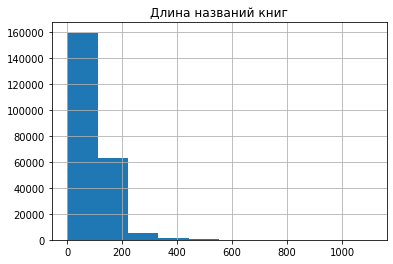

In [42]:
# Добавляем столбец с длиной названий
df_ML['title_length'] = df_ML['title_clear'].str.len()
df_ML.title_length.hist()
plt.title("Длина названий книг")
plt.show()

- Есть пустышки..А есть и мини-эссе на 800 символов!

- Пока не удаляем из общего датасета, главное, выработать общий подход

In [43]:
print("Оочень короткие названия:")
df_ML[df_ML['title_length']  < 5][['title', 'title_clear']].head(10)

Оочень короткие названия:


,title,title_clear
10066,S/Z,sz
14170,Сыр,сыр
14812,Пир,пир
18208,Сид,сид
23587,Пир,пир
27116,1937,
29860,Еда,еда
31141,Т. 1,т
42883,Мать,мать
47725,Роза,роза


- Добавим еще сокращенный вариант названий

In [44]:
df_ML['title_short'] = df_ML['title_clear'].str[0 : 100]
df_ML['title_short_300'] = df_ML['title_clear'].str[0 : 300]

df_ML.sort_values(by='title_length')['title_short'].values

array(['', ' ', ' ', ...,
       'искусство повивания или наука о бабичьем деле на пят частей разделенная и многими рисунками снабденн',
       'искусство повивания или наука о бабичьем деле на пят частей разделенная и многими рисунками снабденн',
       'секретный эконом художник ремесленник заводчик и домашний врач иждивением изаикина ч содержащая в се'],
      dtype=object)

**Вывод**

- Мы подготовили текст, удалив лишние символы, и оставив слова

- Теперь можно проводить эксперименты с леммами и искать похожие названия

##### Удаляем stop-слова

In [45]:
# Расширим название в сокращенной версиии
df_ML['title_no_stop']= df_ML['title_clear'].str[0 : 300]
df_ML.sort_values(by='title_length')['title_no_stop'].values

array(['', ' ', ' ', ...,
       'искусство повивания или наука о бабичьем деле на пят частей разделенная и многими рисунками снабденная в коей кратко но ясно толкуется какое детородныя женские части имеют строение коим образом надлежит пособлять беременным при родах роженицам после родов и новорожденным их младенцам во время младол',
       'искусство повивания или наука о бабичьем деле на пят частей разделенная и многими рисунками снабденная в коей кратко но ясно толкуется какое детородныя женские части имеют строение коим образом надлежит пособлять беременным при родах роженицам после родов и новорожденным их младенцам во время младол',
       'секретный эконом художник ремесленник заводчик и домашний врач иждивением изаикина ч содержащая в себе секреты искусственнаго составления драгоценных камней жемчугу черепаховой кости и проч составления сохранения от порчи золочения и серебрения различных металлов приготовления различнашго рода черни'],
      dtype=object)

In [46]:
# Как выглядят токены-слова
df_ML['title_300_tokens'] = df_ML['title_no_stop'].apply(lambda x: x.split())
df_ML[['title_no_stop', 'title_300_tokens']]

,title_no_stop,title_300_tokens
0,антропонимы в киргизском героическом эпосе ман...,"[антропонимы, в, киргизском, героическом, эпос..."
1,chlorella pyrenoidosa т как тестобъект в биоло...,"[chlorella, pyrenoidosa, т, как, тестобъект, в..."
2,айседора дункан и театральная культура эпохи м...,"[айседора, дункан, и, театральная, культура, э..."
3,записки а и кошелева как памятник отечественно...,"[записки, а, и, кошелева, как, памятник, отече..."
4,аграрная буржуазия в политической жизни индии ...,"[аграрная, буржуазия, в, политической, жизни, ..."
...,...,...
228997,отсутствует,[отсутствует]
228998,отсутствует,[отсутствует]
228999,отсутствует,[отсутствует]
229000,отсутствует,[отсутствует]


- Напишем функцию, чтобы удалить stop-слова, протестируем прямо на этом примере

- (!) часть решения взято со stackoverflow

In [50]:
test_text = "секретный эконом художник ремесленник заводчик и домашний врач иждивением изаикина ч содержащая в себе секреты искусственнаго составления драгоценных камней жемчугу черепаховой кости и проч составления сохранения от порчи золочения и серебрения различных металлов приготовления различнашго рода черни"
test_tokens = test_text.split()
test_tokens[0:5]

['секретный', 'эконом', 'художник', 'ремесленник', 'заводчик']

In [53]:
# Загрузим стоп-слова с внешнего источника
url_stopwords_ru = "https://raw.githubusercontent.com/stopwords-iso/stopwords-ru/master/stopwords-ru.txt"


################################
# Функции для обработки текста
################################

def get_text(url, encoding='utf-8', to_lower=True):
    url = str(url)
    if url.startswith('http'):
        r = requests.get(url)
        if not r.ok:
            r.raise_for_status()
        return r.text.lower() if to_lower else r.text
    elif os.path.exists(url):
        with open(url, encoding=encoding) as f:
            return f.read().lower() if to_lower else f.read()
    else:
        raise Exception('parameter [url] can be either URL or a filename')

def remove_stopwords(tokens, stopwords=None, min_length=4):
    if not stopwords:
        return tokens

    # stopwords = set(stopwords)
    # сокращенный список
    stopwords = nltk_stopwords.words('russian')

    tokens = [tok
              for tok in tokens
              if tok not in stopwords and len(tok) >= min_length]
    return tokens

def lemmatize_tokens(tokens):
    morph = pymorphy2.MorphAnalyzer()
    return [morph.parse(tok)[0].normal_form for tok in tokens]

def clear_and_lemmatize(text, stopwords=None, lemmatize=True):

    # Разделяем текст на токены
    words = [w for w in text.split()]

    if lemmatize:
        words = lemmatize_tokens(words)
    if stopwords:
        words = remove_stopwords(words, stopwords)

    # Возвращаем цельный текст без stop-слов или/и с леммами
    words = " ".join([word for word in words])
                     
    return words

In [56]:
# Загрузим стоп-слова с внешнего источника
stopwords_ru = get_text(url_stopwords_ru).splitlines()

words = clear_and_lemmatize(test_text, stopwords=stopwords_ru, lemmatize=False)
words

'секретный эконом художник ремесленник заводчик домашний врач иждивением изаикина содержащая секреты искусственнаго составления драгоценных камней жемчугу черепаховой кости проч составления сохранения порчи золочения серебрения различных металлов приготовления различнашго рода черни'

- лишние слова удалились!


In [57]:
df_ML['title_no_stop'] = df_ML['title_no_stop'].apply(
    lambda x: clear_and_lemmatize(x,  stopwords=stopwords_ru, lemmatize=False))

In [58]:
# Проверим, как сработало удаление стоп слов
df_ML.iloc[415][['title_no_stop', 'title_clear']].values

array(['порядок слов связь интонацией русском языке сопоставлении китайским автореферат кандидата филологических наук',
       'порядок слов и его связь с интонацией в русском языке в сопоставлении с китайским автореферат дис кандидата филологических наук '],
      dtype=object)

In [59]:
# Сделаем то же самое с коротким названием, возможно, слишком длинное не потребуется
df_ML['title_short_no_stop'] = df_ML['title_short'].apply(
    lambda x: clear_and_lemmatize(x,  stopwords=stopwords_ru, lemmatize=False))

df_ML.iloc[415][['title_short_no_stop', 'title_clear', 'title_no_stop']].values

array(['порядок слов связь интонацией русском языке сопоставлении китайским автореферат',
       'порядок слов и его связь с интонацией в русском языке в сопоставлении с китайским автореферат дис кандидата филологических наук ',
       'порядок слов связь интонацией русском языке сопоставлении китайским автореферат кандидата филологических наук'],
      dtype=object)

**Вывод**

- Лишние слова удалились! Можно испытывать с tfidf!

##### Заменяем на леммы

-  Можно добавить еще одну операцию, перевести слова в неизменяемую форму!

-  Но т.к требует много ресурсов (а у нас они ограничены), пока проработаем с текущим вариантом

In [60]:
# df_ML['title_lemmatized']= df_ML['title_clear'].str[0 : 300]
# df_ML['title_lemmatized'] = df_ML['title_lemmatized'].apply(
    # lambda x: clear_and_lemmatize(x, stopwords=stopwords_ru, lemmatize=True))

In [61]:
# Проверим, как сработала лемматизация
# df_ML.iloc[415][['title_lemmatizied', 'title_no_stop']].values

#### Код BBK и жанры

##### Очистка данных

In [62]:
df_ML.bbk.sort_values()

52699                          \n
178158                         \n
186737                         \n
33704                          \n
94316                          \n
                   ...           
79658                      Я9(2Р)
35260                      Я9(2Р)
9729                       Я9(2Р)
88047     Я9(2Р)\nЧ721,6(2)261я43
96931                     Я9(4Вл)
Name: bbk, Length: 229002, dtype: object

- Еще NaN и \n - не хочется удалять эти книги, посмотрим, есть ли названия и авторы

In [63]:
df_ML[df_ML.bbk.isna()].head(5)

,chb,sys_numb,bbk,title,year_izd,author,year_2,author_ml,title_clear,title_length,title_short,title_short_300,title_no_stop,title_300_tokens,title_short_no_stop


- Пропуски и '\n' заполним нулями


In [64]:
# Заполним пропуски нулями
df_ML['bbk_ml'] = df_ML.bbk.fillna('0')

df_ML.loc[df_ML.bbk_ml.isin(['\n', '\n\n']), 'bbk_ml'] = '0' 
df_ML['bbk_ml'].sort_values().head(10)

145853                              \nВ341.4,0
143245                 \nД9(0)023,0\nР120.10,0
96457                            \nЗ811.3я73-1
177722                   \nЗ973.233-021.3я73-1
58829                \nР.д(2)Кассирский И.А.,0
170741                             \nР126я73-1
43361                              \nР357.4,07
43360                              \nР357.4,07
101231                  \nС555.51,0\nС555.37,0
175642    \nС555.57я431(2)\nЧ611.621с51я431(2)
Name: bbk_ml, dtype: object

Похоже, все коды разделены с помощью \n:

- Заменим разделители \n на пробелы
- Удалим пробелы по краям

In [65]:
# Заменяем '\n' в начале и середине bbk кодов на пробелы
df_ML['bbk_ml'] = df_ML['bbk_ml'].replace("\n", " ", regex=True)
df_ML['bbk_ml'].sort_values().head(10)

145853                              В341.4,0
143245                  Д9(0)023,0 Р120.10,0
96457                            З811.3я73-1
177722                   З973.233-021.3я73-1
58829                Р.д(2)Кассирский И.А.,0
170741                             Р126я73-1
43361                              Р357.4,07
43360                              Р357.4,07
101231                   С555.51,0 С555.37,0
175642     С555.57я431(2) Ч611.621с51я431(2)
Name: bbk_ml, dtype: object

In [66]:
# Проверяем пробелы в начале кодов bbk
df_ML['bbk_ml'].replace(" ", "-", regex=True).sort_values().head(10)

145853                             -В341.4,0
143245                 -Д9(0)023,0-Р120.10,0
96457                           -З811.3я73-1
177722                  -З973.233-021.3я73-1
58829               -Р.д(2)Кассирский-И.А.,0
170741                            -Р126я73-1
43361                             -Р357.4,07
43360                             -Р357.4,07
101231                  -С555.51,0-С555.37,0
175642    -С555.57я431(2)-Ч611.621с51я431(2)
Name: bbk_ml, dtype: object

In [67]:
# Удаляем лишние пробелы в начале
df_ML['bbk_ml'] = df_ML['bbk_ml'].str.strip()

# Проверяем, что все сработало
df_ML['bbk_ml'].replace(" ", "-", regex=True).loc[175642]

'С555.57я431(2)-Ч611.621с51я431(2)'

**Вывод**

1. Мы заменили пропуски и '\n', '\n\n' на '0' (остальные коды выглядят корректно)

2. Убрали разделители '\n':

  - теперь bbk-код можно лего разделить на готовые блоки в TF-IDF! 
  - блоки bbk можно использовать для поиска различных вариаций жанров

##### Сокращенный bbk - для широкого поиска

- Посмотрим на разные варианты и подберем регулярное выражение для сокращенного кода bbk

In [68]:
print("Сложные bbk коды, состоящие из нескольких блоков:")
df_ML[df_ML['bbk_ml'].str.contains(' ')].bbk_ml.head(20)

Сложные bbk коды, состоящие из нескольких блоков:


0                        Ш3(257=Ки)-611,0 Ш163.25-314,0
4                       Т3(5Ид)63-283,02 Т3(5Ид)63-5,02
6     Ш5(2=Р)43-318.3,0 Ш5(2=Р)51-318.3,0 Ш5(0)32-31...
8                          Ш401.171.11,0 Ш5(5Вл)42-35,0
12            Т52(241=А)-417,02 Т594.171.3,02 М772.02,0
13            Т52(241=А)-417,02 Т594.171.3,02 М772.02,0
16       Щ143(2Р=Р)52-8Куинджи А.И.41,0 Щ147.63(2Р=Р),0
18         Т3(53)63-608,014.1 Ч612.4(5Ли)713.1Ан-Нида,0
19                            Щ10г(2)75,0 Щ103(2)75-4,0
20                             Е581.4,0 Е585.9(2Р345),0
23                                   Р343.39,0 Р364.7,0
24               Ш5(2=Р)51-4ПушкинА.С.535,0 Ш141.2-32,0
25                          Н822.207,0 Н712.815-022.5,0
27                             Ш147.11-77,0 Ш141.2-77,0
28                      Ш143.21-212.8,0 Ш143.21-227.4,0
30                           Ш161.131-70,0 Ш161.131-5,0
31                             Ш141.2-221,0 Ш141.2-32,0
35                   Ш151-32,0 Ш143.21-32,0 Ш141

- Попробуем выделить самый первый код, который отвечает за тематику

- Это код из заглавной буквы и последовательности цифр до первого символа "(" или "-" или "." 

In [69]:
df_ML['bbk_top'] = df_ML['bbk_ml'].str.extract(r'(\w\d*)')
df_ML[df_ML['bbk_ml'].str.contains('\n')][['bbk_ml', 'bbk_top']]

,bbk_ml,bbk_top


- Посмотрим, сколько книг у нас получилось для каждого жанра

In [70]:
print("Самые популярные жанры книг в библиотеке:")
df_ML['bbk_top'].value_counts().head(15)

Самые популярные жанры книг в библиотеке:


u       85148
Т3      15063
Ш5      11175
У9       6985
Х629     3978
С555     2624
Х628     2559
Х623     2480
Ш141     2369
Э372     2047
Х621     2010
С556     1759
Ю3       1755
Н0       1465
Щ143     1417
Name: bbk_top, dtype: int64

Самый популярный жанр - теория заговора?)) ТЗ - это история=)

  - На 2-м месте книги для филологов - мировая литература))

  - На 3-м  почетном экономика)

-На 15-м история изобразительного искусства

In [71]:
df_ML['bbk_top'].value_counts().describe()

count     2541.000000
mean        90.122786
std       1743.601303
min          1.000000
25%          2.000000
50%          5.000000
75%         19.000000
max      85148.000000
Name: bbk_top, dtype: float64

**Вывод**

1. Обучать модель можно будет и по полному коду `bbk_ml`, и по начальному `bbk_top`

  - начальный код отражает основную тему в классификационной системе
  - получили его с помощью парсинга

3. Узнали о самых популярных жанрах книг среди читателей:)

3. Все коды bbk можно посмотреть здесь https://lod.rsl.ru/bbkgsk/concepts/%D0%AE9


##### Возможности для TF-IDF

In [72]:
print("Уникальных кодов bbk:", df_ML.bbk_ml.nunique())
print("Сокращенных кодов bbk:", df_ML.bbk_top.nunique())

Уникальных кодов bbk: 79081
Сокращенных кодов bbk: 2541


1. Сокращенные коды будет удобнее использовать для классификации - их всего 2540

2. Чтобы найти специфичную тему нужен более детальный bbk-код

3. 79080  кодов:
  -  почти столько же, сколько и книг (не подойдет для обобщения)
  -  слишком много признаков
---
Решение:

- Закодировать bbk блоками TF-IDF(должно быть много похожих единиц в датасете)


In [73]:
tfidf_vectorizer = TfidfVectorizer()
tfidf =  tfidf_vectorizer.fit_transform(df_ML['bbk_ml'])
tfidf

<229002x27014 sparse matrix of type '<class 'numpy.float64'>'
	with 594713 stored elements in Compressed Sparse Row format>

**Вывод**

- Сработало! 27 000 против 79 000, уже хорошая оптимизация!

- Можно также попробовать использовать для более узкой классификации только первый блок

### (5.4) Алгоритм поиска похожих книг




Посмотрим, какие результаты мы можем получить в поиске похожих названий:

- нужно максимально сократить наши длинные тексты
- выявить наиболее ключевые слова для поиска

Как только доведем до рабочего варианта, будем двигаться дальше

#### По названию





Попробуем искать книги (!) только по названиям (`title`):

- Переведем все наши названия в векторы 

- Текст оставляем как есть (с полным набором слов и выражений)

In [74]:
tfidf_vectorizer = TfidfVectorizer(max_features=20000)
tfidf =  tfidf_vectorizer.fit_transform(df_ML['title_clear'])
tfidf

<229002x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 1797741 stored elements in Compressed Sparse Row format>

- Возьмем произвольную книгу из датасета 

- И попробуем найти книги с похожим названием))

In [86]:
book_title = df_ML.loc[18927].title_clear
book_title

'народные музыкальные инструменты и инструментальная музыка сборник статей и материалов в частях союз композиторов рсфср комиссия музыковедения и фольклора под общей редакцией е в гиппиуса ч '

- Музыка - моя любимая тема! Вот так сюрприз) 

- На первый взгляд специфичная книга, интересно, что сможет найти наш алгоритм в  качестве рекомендации)

In [87]:
book_vector = tfidf_vectorizer.transform([book_title])
book_vector

<1x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 17 stored elements in Compressed Sparse Row format>


- Можно начинать поиск!

In [88]:
# Функция flatten для получения одномерного массива вместо 2D
book_similarities = cosine_similarity(book_vector, tfidf).flatten()

print(book_similarities)

[0. 0. 0. ... 0. 0. 0.]


- Единица  д.б. у исходника - книги, которую мы выбрали 

- Найдем индексы 6 самых похожих книг (с самым большим similarity)


In [89]:
similar_books_id = np.argpartition(book_similarities, -6)[-6:]
print("список похожих книг:")
df_ML.iloc[similar_books_id]

список похожих книг:


,chb,sys_numb,bbk,title,year_izd,author,year_2,author_ml,title_clear,title_length,title_short,title_short_300,title_no_stop,title_300_tokens,title_short_no_stop,bbk_ml,bbk_top
137484,300001075164,RSL01007484789,unknown,Народная инструментальная музыка как феномен к...,2007,"Мациевский, И. В.",2007,Мациевский И В,народная инструментальная музыка как феномен к...,54,народная инструментальная музыка как феномен к...,народная инструментальная музыка как феномен к...,народная инструментальная музыка феномен культуры,"[народная, инструментальная, музыка, как, фено...",народная инструментальная музыка феномен культуры,unknown,u
204679,200001111631,RSL01010581031,Щ313(0)-81я9\nЩ310.9я9,Музыкальные антидеприсанты : 12+,2020,"Казиник, Михаил Семёнович 1951-",2020,Казиник Михаил Семёнович,музыкальные антидеприсанты,27,музыкальные антидеприсанты,музыкальные антидеприсанты,музыкальные антидеприсанты,"[музыкальные, антидеприсанты]",музыкальные антидеприсанты,Щ313(0)-81я9 Щ310.9я9,Щ313
88322,100000904657,RSL01004334095,Щ315.3я20,Музыкальные инструменты : энциклопедия,2008,none,2008,none,музыкальные инструменты энциклопедия,36,музыкальные инструменты энциклопедия,музыкальные инструменты энциклопедия,музыкальные инструменты энциклопедия,"[музыкальные, инструменты, энциклопедия]",музыкальные инструменты энциклопедия,Щ315.3я20,Щ315
132681,100000937133,RSL01006913745,Щ315.32(2Р=Р)-3,Русские народные музыкальные инструменты,1975,"Вертков, Константин Александрович",1975,Вертков Константин Александрович,русские народные музыкальные инструменты,41,русские народные музыкальные инструменты,русские народные музыкальные инструменты,русские народные музыкальные инструменты,"[русские, народные, музыкальные, инструменты]",русские народные музыкальные инструменты,Щ315.32(2Р=Р)-3,Щ315
18927,100000904657,RSL01001387801,Щ315.32я43,Народные музыкальные инструменты и инструмента...,1987,none,1987,none,народные музыкальные инструменты и инструмента...,190,народные музыкальные инструменты и инструмента...,народные музыкальные инструменты и инструмента...,народные музыкальные инструменты инструменталь...,"[народные, музыкальные, инструменты, и, инстру...",народные музыкальные инструменты инструменталь...,Щ315.32я43,Щ315
132682,300000922871,RSL01006913745,Щ315.32(2Р=Р)-3,Русские народные музыкальные инструменты,1975,"Вертков, Константин Александрович",1975,Вертков Константин Александрович,русские народные музыкальные инструменты,41,русские народные музыкальные инструменты,русские народные музыкальные инструменты,русские народные музыкальные инструменты,"[русские, народные, музыкальные, инструменты]",русские народные музыкальные инструменты,Щ315.32(2Р=Р)-3,Щ315


- Под индексом 160955 прячется наша книга

- Сколько еще книг про музыкальные инструменты (есть и 2008, и старые издания 1975)

Хороший поиск! Посмотрим еще какую-нибудь книгу=)

In [99]:
book_title = df_ML.loc[197369].title_clear
book_title

'легенды о египетских богах'

- Интересное попадание:) Тайны Египта)

In [100]:
# Переводим в вектор
book_vector = tfidf_vectorizer.transform([book_title])

# Получаем матрицу с похожими названиями
book_similarities = cosine_similarity(book_vector, tfidf).flatten()
similar_books_id = np.argpartition(book_similarities, -6)[-6:]

print("список похожих книг:")
df_ML.iloc[similar_books_id]

список похожих книг:


,chb,sys_numb,bbk,title,year_izd,author,year_2,author_ml,title_clear,title_length,title_short,title_short_300,title_no_stop,title_300_tokens,title_short_no_stop,bbk_ml,bbk_top
35153,300001000175,RSL01002402303,Ш5(2=Р)75-644.3,Легенды о графе Брюсе,2003,"Баранов, Евгений Захарович",2003,Баранов Евгений Захарович,легенды о графе брюсе,21,легенды о графе брюсе,легенды о графе брюсе,легенды графе брюсе,"[легенды, о, графе, брюсе]",легенды графе брюсе,Ш5(2=Р)75-644.3,Ш5
193348,200000789223,RSL01010192570,Ш3(41Нр)-615.20\nШ3(0)948-615.20\nШ5(0)42-601,"Норвежские, кельтские и тевтонские легенды : 16+",сор. 2020,"Вегнер, Вильгельм 1800-1886",2020,Вегнер Вильгельм,норвежские кельтские и тевтонские легенды,42,норвежские кельтские и тевтонские легенды,норвежские кельтские и тевтонские легенды,норвежские кельтские тевтонские легенды,"[норвежские, кельтские, и, тевтонские, легенды]",норвежские кельтские тевтонские легенды,Ш3(41Нр)-615.20 Ш3(0)948-615.20 Ш5(0)42-601,Ш3
36262,200001031401,RSL01002437129,"Т3(0)310,012\nЭ321.0-503.21,12",О египетских мистериях,2004,Ямвлих 245/280-325/330 н. э.,2004,Ямвлих н э,о египетских мистериях,23,о египетских мистериях,о египетских мистериях,египетских мистериях,"[о, египетских, мистериях]",египетских мистериях,"Т3(0)310,012 Э321.0-503.21,12",Т3
29071,300001068174,RSL01001797101,unknown,Легенды о египетских богах : Перевод,1997,"Бадж, Эрнест Альфред Уоллес 1857-1934",1997,Бадж Эрнест Альфред Уоллес,легенды о египетских богах перевод,34,легенды о египетских богах перевод,легенды о египетских богах перевод,легенды египетских богах перевод,"[легенды, о, египетских, богах, перевод]",легенды египетских богах перевод,unknown,u
197368,300001006250,RSL01010319297,"Э321.0-421.1,0",Легенды о египетских богах,2019,"Бадж, Эрнест Альфред Уоллес 1857-1934",2019,Бадж Эрнест Альфред Уоллес,легенды о египетских богах,26,легенды о египетских богах,легенды о египетских богах,легенды египетских богах,"[легенды, о, египетских, богах]",легенды египетских богах,"Э321.0-421.1,0",Э321
197369,300001068174,RSL01010319297,"Э321.0-421.1,0",Легенды о египетских богах,2019,"Бадж, Эрнест Альфред Уоллес 1857-1934",2019,Бадж Эрнест Альфред Уоллес,легенды о египетских богах,26,легенды о египетских богах,легенды о египетских богах,легенды египетских богах,"[легенды, о, египетских, богах]",легенды египетских богах,"Э321.0-421.1,0",Э321


- Все варианты хороши) Интересно почитать норвежские легенды 16+

- Возьмем еще один из длинных текстов

In [101]:
# Берем рандомную книгу с очень длинным названием
book_title = df_ML[df_ML.title_length > 300].sample(1, random_state=123).title_clear.values[0]
print(book_title)

# Переводим в вектор
book_vector = tfidf_vectorizer.transform([book_title])

# Получаем матрицу с похожими названиями
book_similarities = cosine_similarity(book_vector, tfidf).flatten()
similar_books_id = np.argpartition(book_similarities, -6)[-6:]

print("список похожих книг:")
df_ML.iloc[similar_books_id]  

политическое проектирование в пространстве социальных коммуникаций материалы x международной научной конференции москва октября ноября г минобрнауки россии федеральное гос бюджетное образовательное учреждение высш проф образования российский гос гуманитарный унт рггу фак истории политологии и права общероссийская общественная орг российская ассоц политической науки рапн редкол а п логунов отв ред и др теория методология и методики политического проектирования коммуникативные практики и технологии политического проектирования политические партии как субъекты и объекты политического проектирования
список похожих книг:


,chb,sys_numb,bbk,title,year_izd,author,year_2,author_ml,title_clear,title_length,title_short,title_short_300,title_no_stop,title_300_tokens,title_short_no_stop,bbk_ml,bbk_top
124038,200001118720,RSL01006541595,Т2я431(0),Вспомогательные исторические дисциплины в совр...,2013,none,2013,none,вспомогательные исторические дисциплины в совр...,411,вспомогательные исторические дисциплины в совр...,вспомогательные исторические дисциплины в совр...,вспомогательные исторические дисциплины соврем...,"[вспомогательные, исторические, дисциплины, в,...",вспомогательные исторические дисциплины соврем...,Т2я431(0),Т2
164370,300001050552,RSL01008817005,С555.51я431(0),Политическое проектирование в пространстве соц...,2016,none,2016,none,политическое проектирование в пространстве соц...,130,политическое проектирование в пространстве соц...,политическое проектирование в пространстве соц...,политическое проектирование пространстве социа...,"[политическое, проектирование, в, пространстве...",политическое проектирование пространстве социа...,С555.51я431(0),С555
114481,100000926172,RSL01005482683,Ю9я43,Психосфера : сборник научных трудов кафедры пс...,2012,none,2012,none,психосфера сборник научных трудов кафедры псих...,207,психосфера сборник научных трудов кафедры псих...,психосфера сборник научных трудов кафедры псих...,психосфера сборник научных трудов кафедры псих...,"[психосфера, сборник, научных, трудов, кафедры...",психосфера сборник научных трудов кафедры псих...,Ю9я43,Ю9
65104,200001031401,RSL01003393841,"С555.511,0\nЦ35(0)-2",Теория партизана : промежуточное замечание к п...,2007,"Шмитт, Карл 1888-1985",2007,Шмитт Карл,теория партизана промежуточное замечание к пон...,64,теория партизана промежуточное замечание к пон...,теория партизана промежуточное замечание к пон...,теория партизана промежуточное замечание понят...,"[теория, партизана, промежуточное, замечание, ...",теория партизана промежуточное замечание понят...,"С555.511,0 Ц35(0)-2",С555
138420,300001050552,RSL01007514150,С555.51я431(0),Политическое проектирование в пространстве соц...,2013,none,2013,none,политическое проектирование в пространстве соц...,602,политическое проектирование в пространстве соц...,политическое проектирование в пространстве соц...,политическое проектирование пространстве социа...,"[политическое, проектирование, в, пространстве...",политическое проектирование пространстве социа...,С555.51я431(0),С555
138485,300001050552,RSL01007516055,unknown,Политическое проектирование в пространстве соц...,2013,none,2013,none,политическое проектирование в пространстве соц...,660,политическое проектирование в пространстве соц...,политическое проектирование в пространстве соц...,политическое проектирование пространстве социа...,"[политическое, проектирование, в, пространстве...",политическое проектирование пространстве социа...,unknown,u


- Отлично!

- Подберем такой набор для каждой книги (это нам пригодится, когда будем готовить рекомендации для каждого пользователя)

**Вывод**

1. Без дополнительной обработки текста мы уже получили неплохие `рекомендации` по названиям` книг

  - "+"  Читатель может открыть для себя новые книги и авторов
  - "+"  Можно использовать для разовых запросов читателей
  - "-"  Очень большое количество признаков
  - "-"  Без оптимизации подхода мы не сможем использовать названия для "попарного" поиска похожих книг в библиотеке.

2. Возможности для улучшения:
  - Сократить длину описаний для обучения
  - Отсеять "stop"-слова 
  - Использовать SVD для сокращения количества признаков
  - Перевести в леммы (сейчас "Марсиане" и "Марсианские" будут давать разные результаты)




#### По жанру




1. Попробуем найти похожие книги по жанру!

  - Есть идея не кодировать полный bbk, а применить к нему TF-IDF 

2. Сокращеннный bbk_top должен дать большой широкий выбор в тематике книг)

  - Проверим оба варианта!


Интересно, что получится:)


In [106]:
# Находим рандомную книгу
random_book = df_ML.loc[115909]
display(random_book)


chb                                         300001057484
sys_numb                                  RSL01005529118
bbk                                           Э391.229,0
title                     Практика развития ясновидения 
year_izd                                            2012
author                                   Муратова, Ольга
year_2                                              2012
author_ml                                 Муратова Ольга
title_clear               практика развития ясновидения 
title_length                                          30
title_short               практика развития ясновидения 
title_short_300           практика развития ясновидения 
title_no_stop              практика развития ясновидения
title_300_tokens       [практика, развития, ясновидения]
title_short_no_stop        практика развития ясновидения
bbk_ml                                        Э391.229,0
bbk_top                                             Э391
Name: 115909, dtype: object

- Ясновидение, это что-то новенькое!

In [23]:
def test_tf_idf_recommender(df, features_col, search_item, top_count, max_features=100000):

  """
  Создает TF-IDF Vectorizer для features_col и выводит ТОP похожих книг
  """

  # Переводим все признаки df[features_col] в набор векторов tfidf
  tfidf_vectorizer = TfidfVectorizer(max_features=max_features)
  tfidf =  tfidf_vectorizer.fit_transform(df[features_col])
  tfidf

  # Генерируем вектор для search_item
  book_vector = tfidf_vectorizer.transform([search_item])

  # Создаем матрицу с расстояниями до признака search_item
  book_similarities = cosine_similarity(book_vector, 
                                        tfidf).flatten()

  # Получаем индексы книг самыми похожими признаками
  similar_books_id = np.argpartition(book_similarities,
                                     top_count*(-1))[top_count*(-1):]
   
  # Печатаем размер tfidf матрицы
  display(tfidf)

  # Выводим описания TOP похожих книг
  display(df.iloc[similar_books_id]) 


In [112]:
# Рекомендации на СОКРАЩЕННЫХ кодах bbk
print("Рекомендации по жанру для 'Практика развития ясновидения'")
test_tf_idf_recommender(df_ML, 'bbk_ml', 
                        random_book.bbk_ml, 
                        top_count=6)

Рекомендации по жанру для 'Практика развития ясновидения'


<229002x27014 sparse matrix of type '<class 'numpy.float64'>'
	with 594713 stored elements in Compressed Sparse Row format>

,chb,sys_numb,bbk,title,year_izd,author,year_2,author_ml,title_clear,title_length,title_short,title_short_300,title_no_stop,title_300_tokens,title_short_no_stop,bbk_ml,bbk_top
126693,300001057484,RSL01006635888,"Э391.229,0",Практика развития ясновидения : для лиц старше...,2013,"Муратова, Ольга",2013,Муратова Ольга,практика развития ясновидения для лиц старше лет,48,практика развития ясновидения для лиц старше лет,практика развития ясновидения для лиц старше лет,практика развития ясновидения старше,"[практика, развития, ясновидения, для, лиц, ст...",практика развития ясновидения старше,"Э391.229,0",Э391
198811,300001071113,RSL01010364988,"Э391.229,0",Большая книга магической силы : развитие интуи...,cop. 2020,"Моносов, Борис Моисеевич",2020,Моносов Борис Моисеевич,большая книга магической силы развитие интуици...,62,большая книга магической силы развитие интуици...,большая книга магической силы развитие интуици...,большая книга магической силы развитие интуици...,"[большая, книга, магической, силы, развитие, и...",большая книга магической силы развитие интуици...,"Э391.229,0",Э391
126761,300001057484,RSL01006638467,"Э391.229,0",Вы - ясновидящий! Как открыть третий глаз,2013,"Муратова, Ольга Николаевна",2013,Муратова Ольга Николаевна,вы ясновидящий как открыть третий глаз,39,вы ясновидящий как открыть третий глаз,вы ясновидящий как открыть третий глаз,ясновидящий открыть третий глаз,"[вы, ясновидящий, как, открыть, третий, глаз]",ясновидящий открыть третий глаз,"Э391.229,0",Э391
103641,200000789223,RSL01004995491,"Э391.229,0",Счастье по-ру-ски,2011,"Никитенко, Арсения Петровна",2011,Никитенко Арсения Петровна,счастье поруски,16,счастье поруски,счастье поруски,счастье поруски,"[счастье, поруски]",счастье поруски,"Э391.229,0",Э391
137695,100000926172,RSL01007489797,"Э391.229,0",Моя жизнь провидца : потерянные мемуары : 16+,2014,"Кейси, Эдгар 1877-1945",2014,Кейси Эдгар,моя жизнь провидца потерянные мемуары,38,моя жизнь провидца потерянные мемуары,моя жизнь провидца потерянные мемуары,жизнь провидца потерянные мемуары,"[моя, жизнь, провидца, потерянные, мемуары]",жизнь провидца потерянные мемуары,"Э391.229,0",Э391
124278,300001090509,RSL01006550496,"Э391.229,0",Тайны великих предсказаний : 16+,2013,"Кубеев, Михаил Николаевич",2013,Кубеев Михаил Николаевич,тайны великих предсказаний,27,тайны великих предсказаний,тайны великих предсказаний,тайны великих предсказаний,"[тайны, великих, предсказаний]",тайны великих предсказаний,"Э391.229,0",Э391


**Вывод 1**

Действительно, мы получили книги из различной **эзотерической литературы** (счастье по-руски, конечно, вершина рекомендаций:))

1. Такой подход интересен, т.к. читатель точно найдет `что-то новое`!

2. Для ранжирования удобно, когда также есть `рейтинг пользователей` 
  - тогда мы могли бы дать список из самых популярных книг

Теперь посмотрим, что будет, если взять для сравнения полный bbk-код

In [115]:
# Рекомендации на ПОЛНЫХ кодах bbk
print("Рекомендации по жанру для 'Практика развития ясновидения'")
test_tf_idf_recommender(df_ML, 'bbk_top', 
                        random_book['bbk_top'], 
                        top_count=6)

Рекомендации по жанру для 'Практика развития ясновидения'


<229002x2516 sparse matrix of type '<class 'numpy.float64'>'
	with 141310 stored elements in Compressed Sparse Row format>

,chb,sys_numb,bbk,title,year_izd,author,year_2,author_ml,title_clear,title_length,title_short,title_short_300,title_no_stop,title_300_tokens,title_short_no_stop,bbk_ml,bbk_top
84143,300001058749,RSL01004159566,"Э391.211,0",Прелестница Венера и волшебник Нептун. 144 сце...,2008,"Йеле, Маркус 1958-",2008,Йеле Маркус,прелестница венера и волшебник нептун сценария...,73,прелестница венера и волшебник нептун сценария...,прелестница венера и волшебник нептун сценария...,прелестница венера волшебник нептун сценария с...,"[прелестница, венера, и, волшебник, нептун, сц...",прелестница венера волшебник нептун сценария с...,"Э391.211,0",Э391
139919,300001051926,RSL01007564549,"Э391.5,0",Спиритизм в истории,2014,"Барабаш, Е.",2014,Барабаш Е,спиритизм в истории,20,спиритизм в истории,спиритизм в истории,спиритизм истории,"[спиритизм, в, истории]",спиритизм истории,"Э391.5,0",Э391
88512,300001033994,RSL01004339728,"Э391.215,0",Энциклопедия Арканов Таро Кроули. Полная интер...,2009,"Банцхаф, Хайо",2009,Банцхаф Хайо,энциклопедия арканов таро кроули полная интерп...,59,энциклопедия арканов таро кроули полная интерп...,энциклопедия арканов таро кроули полная интерп...,энциклопедия арканов таро кроули полная интерп...,"[энциклопедия, арканов, таро, кроули, полная, ...",энциклопедия арканов таро кроули полная интерп...,"Э391.215,0",Э391
198494,200001132993,RSL01010352556,"Э391.211,0",Чёрная лунаа за левым плечом,2020,"Кузнецова, Елена",2020,Кузнецова Елена,чёрная лунаа за левым плечом,28,чёрная лунаа за левым плечом,чёрная лунаа за левым плечом,чёрная лунаа левым плечом,"[чёрная, лунаа, за, левым, плечом]",чёрная лунаа левым плечом,"Э391.211,0",Э391
144294,300000945698,RSL01007879582,"Э391.215,0",Магическое Таро Алистера Кроули,2015,none,2015,none,магическое таро алистера кроули,32,магическое таро алистера кроули,магическое таро алистера кроули,магическое таро алистера кроули,"[магическое, таро, алистера, кроули]",магическое таро алистера кроули,"Э391.215,0",Э391
11271,200001031401,RSL01000725135,"Э391.8,0",Герметическая космогония,2001,none,2001,none,герметическая космогония,25,герметическая космогония,герметическая космогония,герметическая космогония,"[герметическая, космогония]",герметическая космогония,"Э391.8,0",Э391


**Вывод 2**

Классно! Очень крутая подборка получилась)

1. Если брать полный bbk + TFIDF
  - получаем интересные подборки по конкретной тематике:)

2. Задача нашей системы найти для читателя неожиданные книги, которые понравятся)
  - такой подход не может улучшить нашу метрику на предсказаниях (т.к. мы предсказываем не рейтинг, а факт выдачи книг)
  - зато мы построим систему с хорошими рекомендациями!

3. "+" В дополнение мы сразу нашли `новых пользователей` по интересам!

Возможности для развития - в TFIDF разделить bbk на несколько блоков, тогда можно комбинировать подходы и находить еще более интересные варианты рекомендаций)

#### По автору и жанру



Объединим для поиска авторов и жанры:

- протестируем подход с полным bbk
- с top bbk (только широкая классификация)

In [116]:
df_ML['author_bbk'] = df_ML['bbk_ml'].astype('string') + " " + df_ML['author_ml']
df_ML['author_bbk']

0         Ш3(257=Ки)-611,0 Ш163.25-314,0 Боронов Адина А...
1                     Е591.21с,0 Дедов Александр Викторович
2         Щ327.75(7США)-86ДунканА.0,0 Добротворская Кари...
3         Ш5(2=Р)52-4КошелевА.И.534,0 Летягин Лев Никола...
4         Т3(5Ид)63-283,02 Т3(5Ид)63-5,02 Литвин Алексей...
                                ...                        
228997                                  unknown отсутствует
228998                                  unknown отсутствует
228999                                  unknown отсутствует
229000                                  unknown отсутствует
229001                                  unknown отсутствует
Name: author_bbk, Length: 229002, dtype: string

- На поиск "Принцесса на горошине" вышла книга, написанная самой Дианой Уэльской

- Попробуем найти похожие книги

In [118]:
test_tf_idf_recommender(df_ML, 'author_bbk', 
                        df_ML.loc[112657]['author_bbk'], 
                        top_count=3)

<229002x89025 sparse matrix of type '<class 'numpy.float64'>'
	with 1139026 stored elements in Compressed Sparse Row format>

,chb,sys_numb,bbk,title,year_izd,author,year_2,author_ml,title_clear,title_length,title_short,title_short_300,title_no_stop,title_300_tokens,title_short_no_stop,bbk_ml,bbk_top,author_bbk
99190,300000939151,RSL01004855601,"Т3(4Вл)511.9-8Карл I,02",Образы Карла I Стюарта в политической полемике...,2011,"Кирьянова, Елена Анатольевна",2011,Кирьянова Елена Анатольевна,образы карла i стюарта в политической полемике...,131,образы карла i стюарта в политической полемике...,образы карла i стюарта в политической полемике...,образы карла стюарта политической полемике нач...,"[образы, карла, i, стюарта, в, политической, п...",образы карла стюарта политической полемике нач...,"Т3(4Вл)511.9-8Карл I,02",Т3,"Т3(4Вл)511.9-8Карл I,02 Кирьянова Елена Анатол..."
139364,300000974405,RSL01007547124,\n,"Принцесса Диана. Жизнь, рассказанная ею самой ...",2014,Диана принцесса Уэльская 1961-1997,2014,Диана принцесса Уэльская,принцесса диана жизнь рассказанная ею самой,44,принцесса диана жизнь рассказанная ею самой,принцесса диана жизнь рассказанная ею самой,принцесса диана жизнь рассказанная самой,"[принцесса, диана, жизнь, рассказанная, ею, са...",принцесса диана жизнь рассказанная самой,0,0,0 Диана принцесса Уэльская
112657,300000974405,RSL01005432559,"Т3(4Вл)63-8Карл Уэльский21,013.1","Принцесса Диана. Жизнь, рассказанная ею самой",2012,Диана принцесса Уэльская 1961-1997,2012,Диана принцесса Уэльская,принцесса диана жизнь рассказанная ею самой,44,принцесса диана жизнь рассказанная ею самой,принцесса диана жизнь рассказанная ею самой,принцесса диана жизнь рассказанная самой,"[принцесса, диана, жизнь, рассказанная, ею, са...",принцесса диана жизнь рассказанная самой,"Т3(4Вл)63-8Карл Уэльский21,013.1",Т3,"Т3(4Вл)63-8Карл Уэльский21,013.1 Диана принцес..."


**Вывод1**

1.  Поиск работает хорошо, но 89 000 признаков -  это очень много 

2. Две книги с похожим названием, но разными идентификаторами! Потому что разный год издания!!

  - Проверим в следующем, есть ли еще такие явные дубликаты в датасете

Попробуем теперь сокращенный вариант bbk.

In [119]:
df_ML['author_bbk'] = df_ML['bbk_top'].astype('string') + " " + df_ML['author_ml']
df_ML['author_bbk']

0                   Ш3 Боронов Адина Айылчиевич
1               Е591 Дедов Александр Викторович
2         Щ327 Добротворская Карина Анатольевна
3                     Ш5 Летягин Лев Николаевич
4                  Т3 Литвин Алексей Васильевич
                          ...                  
228997                            u отсутствует
228998                            u отсутствует
228999                            u отсутствует
229000                            u отсутствует
229001                            u отсутствует
Name: author_bbk, Length: 229002, dtype: string

In [121]:
test_tf_idf_recommender(df_ML, 'author_bbk', 
                        df_ML.loc[112657]['author_bbk'], 
                        top_count=3)

<229002x66250 sparse matrix of type '<class 'numpy.float64'>'
	with 686639 stored elements in Compressed Sparse Row format>

,chb,sys_numb,bbk,title,year_izd,author,year_2,author_ml,title_clear,title_length,title_short,title_short_300,title_no_stop,title_300_tokens,title_short_no_stop,bbk_ml,bbk_top,author_bbk
50471,200001049489,RSL01002908021,"Т3(2)522.9-484.27,02\nФ69(2)421.7,0",Всероссийский крестьянский союз в 1905-1907 гг.,2006,"Колесниченко, Диана Алексеевна",2006,Колесниченко Диана Алексеевна,всероссийский крестьянский союз в гг,36,всероссийский крестьянский союз в гг,всероссийский крестьянский союз в гг,всероссийский крестьянский союз,"[всероссийский, крестьянский, союз, в, гг]",всероссийский крестьянский союз,"Т3(2)522.9-484.27,02 Ф69(2)421.7,0",Т3,Т3 Колесниченко Диана Алексеевна
139364,300000974405,RSL01007547124,\n,"Принцесса Диана. Жизнь, рассказанная ею самой ...",2014,Диана принцесса Уэльская 1961-1997,2014,Диана принцесса Уэльская,принцесса диана жизнь рассказанная ею самой,44,принцесса диана жизнь рассказанная ею самой,принцесса диана жизнь рассказанная ею самой,принцесса диана жизнь рассказанная самой,"[принцесса, диана, жизнь, рассказанная, ею, са...",принцесса диана жизнь рассказанная самой,0,0,0 Диана принцесса Уэльская
112657,300000974405,RSL01005432559,"Т3(4Вл)63-8Карл Уэльский21,013.1","Принцесса Диана. Жизнь, рассказанная ею самой",2012,Диана принцесса Уэльская 1961-1997,2012,Диана принцесса Уэльская,принцесса диана жизнь рассказанная ею самой,44,принцесса диана жизнь рассказанная ею самой,принцесса диана жизнь рассказанная ею самой,принцесса диана жизнь рассказанная самой,"[принцесса, диана, жизнь, рассказанная, ею, са...",принцесса диана жизнь рассказанная самой,"Т3(4Вл)63-8Карл Уэльский21,013.1",Т3,Т3 Диана принцесса Уэльская


- 66 000 признаков, уже лучше!

**Вывод 2**

1. Мы реализовали подход к поиску похожих книг по автору и жанру:

  - будет находить похожие книги (из одного сборника или серии)

2. Использование сокращенного bbk:
  -  дает такие же результаты
  -  признаков почти в 2 раза меньше! 

3. Есть плюсы и минусы:

- "+" - здесь потребуется меньше признаков, чем с поиском по названиям
- "+" - сможем использовать для улучшения качества предсказаний
---
- "-" - читатель, скорее всего, не откроет для себя новых авторов


## ЭТАП 6. HYBRID-Рекомендательная система

#### (6.1) Проблематика

Для одной книги легко найти похожие, но у нас 9000 пользователей и 188 000 уникальных книг!

В системе рекомендаций потребуется более `оптимальный подход`:

- сократить набор признаков для вычисления расстояний cousine similarity

- придумать, как мы будем подбирать похожие книги для **набора из 3-200 книг**, которые уже прочитал пользователь:)

- выбрать подход к ранжированию (сложность в том, что у нас нет рейтингов, а в наборе может быть до 200 книг - как делать для них рекомендации?)

#### Вычисление similarities



##### Датафрейм с книгами для обучения

In [122]:
# Датасет с набором книг из транзакций, из которого будем подбирать рекомендации
items_ML = (df_ML[['sys_numb', 'bbk_ml', 'title_clear', 'bbk_top', 'author_ml', 
                   'title_short', 'title_no_stop', 'title_short_no_stop']]
            .drop_duplicates()
            .reset_index(drop=True))

print("Количество книг для content-based рекомендаций:", items_ML.shape[0])

Количество книг для content-based рекомендаций: 194666


In [123]:
# Сохраняем датафрейм для обучения
# items_ML.to_csv("items_ML.csv", index=False)

In [10]:
# Загружаем датафрейм для экспериментов
items_ML = pd.read_csv("items_ML.csv")

In [11]:
# Посмотрим, где выйдут пропуски - книги без названий
items_ML[items_ML.title_no_stop.isna()]

,sys_numb,bbk_ml,title_clear,bbk_top,author_ml,title_short,title_no_stop,title_short_no_stop
5963,RSL01000626391,"Т3(4Ф)64-05,013.1 Т3(2)74-8ГорбачевМ.С.20,013.1",как это было,Т3,Горбачев Михаил Сергеевич,как это было,NaN,NaN
8660,RSL01000699019,Ю3(4Фр)6-664БартР.-06,sz,Ю3,Барт Ролан,sz,NaN,NaN
12006,RSL01000955918,Л958я20 Л992.8я27,сыр,Л958,Петухова Елена Юрьевна,сыр,NaN,NaN
12547,RSL01000970071,Ш5(2=Р)75-644,пир,Ш5,Сорокин Владимир Георгиевич,пир,NaN,NaN
15519,RSL01001337100,unknown,сид,u,Корнель Пьер,сид,NaN,NaN
...,...,...,...,...,...,...,...,...
167551,RSL01010319897,"Э38-422.27,0",рай и ад,Э38,альАшкар Умар Сулейман,рай и ад,NaN,NaN
169922,RSL01010424386,Ш5(2=Р)64-644,другой юг,Ш5,Абдуллаев Шамшад,другой юг,NaN,NaN
172489,RSL01010538496,Р282.11я9,дар и я,Р282,Солнышко,дар и я,NaN,NaN
173178,RSL01010564698,"Д8г(5Ту)42,0 Д890(0),0",,Д8,,,NaN,NaN


In [12]:
items_ML = items_ML.fillna("")

- Всего 62, но рай и сыр не попали - т.к. мы удалили слова из 3 букв

##### Новый подход - оптимизация ресурсов

Попробуем сразу вычислить попарные "расстояния" для всех книг по жанрам.

- тогда мы сможем пользоваться готовой матрицей при подборе рекомендаций для **набора книг**

Сколько времени это займет?

In [13]:
# Создаем матрицу TF-IDF для векторизации книг по жанрам
tfidf_vectorizer = TfidfVectorizer()
tfidf =  tfidf_vectorizer.fit_transform(items_ML['bbk_top'])
tfidf

<194666x2516 sparse matrix of type '<class 'numpy.float64'>'
	with 117518 stored elements in Compressed Sparse Row format>

In [14]:
tfidf_vectorizer.vocabulary_

{'ш3': 2189,
 'е591': 442,
 'щ327': 2276,
 'ш5': 2198,
 'т3': 1785,
 'р11': 1601,
 'у9': 1858,
 'ш401': 2193,
 'с73': 1756,
 'р266': 1626,
 'т52': 1793,
 'д23': 294,
 'з973': 695,
 'щ143': 2240,
 'п034': 1439,
 'щ10': 2216,
 'е581': 437,
 'р343': 1635,
 'н822': 1269,
 'т4': 1786,
 'ш147': 2162,
 'ш143': 2159,
 'ю215': 2392,
 'ш161': 2169,
 'ш141': 2157,
 'р645': 1700,
 'ш151': 2164,
 'е071': 376,
 'у03': 1804,
 'п398': 1526,
 'е072': 377,
 'п214': 1482,
 'ф61': 1861,
 'п065': 1450,
 'щ03': 2215,
 'д244': 303,
 'р453': 1666,
 'р413': 1657,
 'р410': 1654,
 'п347': 1516,
 'ц35': 1977,
 'р811': 1732,
 'ю462': 2423,
 'п082': 1458,
 'х629': 1897,
 'р733': 1730,
 'ю948': 2467,
 'к391': 782,
 'п062': 1447,
 'с556': 1744,
 'р281': 1629,
 'з86': 674,
 'ю936': 2456,
 'ш100': 2143,
 'ч421': 2044,
 'р252': 1620,
 'н761': 1242,
 'х919': 1955,
 'в171': 74,
 'р124': 1606,
 'д453': 334,
 'р121': 1604,
 'х910': 1946,
 'ц4': 1978,
 'в378': 133,
 'н101': 1160,
 'д9': 354,
 'щ154': 2247,
 'ю952': 2471,
 'х

- Для запуска нужно раскомментировать код ниже

In [14]:
# from sklearn.metrics.pairwise import linear_kernel
# book_similarities = linear_kernel(tfidf, tfidf)

Проблема:

- Это удобный подход для учебных демонстраций и небольшого количества признаков, но не для 200 000 книг!

- Оперативная память не выдерживает таких объемов, а если использовать цикл с cosine similarities, он зависает на вечность
---
Решение:

Попробуем воспользоваться перемножением матриц и форматом Compressed Sparse Column! 

In [15]:
def fast_cosine_similarities(sparse_matrix, axis_type=1):

  # матрица mxn
  # m - объекты, n - признаки
  # нормализуем все строки или столбцы, в зависимости от axis
  csc_matrix = pp.normalize(sparse_matrix.tocsc(), axis=axis_type)
   
  transposed = csc_matrix.T
  # расстояния между объектами-строками 
  # матрица mxm
  if axis_type == 1:
    return csc_matrix * transposed
  # расстояния между признаками-столбцами
  # матрица nxn
  else:    
    return transposed * csc_matrix


In [17]:
sim_matrix = fast_cosine_similarities(tfidf, axis_type=1)
sim_matrix

<194666x194666 sparse matrix of type '<class 'numpy.float64'>'
	with 340418886 stored elements in Compressed Sparse Row format>

- Супер! Все быстро посчитано за секунды!

**Вывод**

1. Перемножение матриц - отличное решение для рассчета расстояний!

2. Конечно, оперативку мы все-таки загрузили  ~6ГБ, НО!

  - работает, и в тысячи раз быстрее чем cousine_similarity или linear_kernel
  - можно попробовать сохранять на диск, а в оперативку загружать уже построчно или чанками.

Сравним теперь результаты вычислений с поиском с помощью cosine_similarity.
Очень надеемся, что они совпадут, и можно будет использовать для рекомендаций)


##### Корректность результатов

- Индексы в TF-IDF соответствуют индексам в датафрейме с книгами, который мы преобразовывали в векторы

- Найдем индекс для той самой книги  "с ясновидением"

In [18]:
items_ML[items_ML['sys_numb']== "RSL01005529118"]

,sys_numb,bbk_ml,title_clear,bbk_top,author_ml,title_short,title_no_stop,title_short_no_stop
97897,RSL01005529118,"Э391.229,0",практика развития ясновидения,Э391,Муратова Ольга,практика развития ясновидения,практика развития ясновидения,практика развития ясновидения


In [19]:
 # Переводим в np array строку с расстояниями до других items
item_similarities  = sim_matrix[61744, :].toarray()
display(item_similarities)

# flatten - для перевода из 2D в 1D
item_similarities = item_similarities.flatten()
display(item_similarities)

array([[0., 0., 0., ..., 0., 0., 0.]])

array([0., 0., 0., ..., 0., 0., 0.])

In [20]:
 # Получаем индексы 6 самых похожих items
similar_books_id = np.argpartition(item_similarities, -6)[-6:]
similar_books_id

array([ 64895,  64891,  64887,  64889,  64888, 194665])

Проверим результаты поиска обоих методов!
- с заранее сгенерированной матрицей с новым подходом
- с cosine_similarity 

In [21]:
items_ML.iloc[similar_books_id]

,sys_numb,bbk_ml,title_clear,bbk_top,author_ml,title_short,title_no_stop,title_short_no_stop
64895,RSL01003882679,unknown,избранные сочинения иеремии бентама пер по анг...,u,Бентам Иеремия,избранные сочинения иеремии бентама пер по анг...,избранные сочинения иеремии бентама англ боури...,избранные сочинения иеремии бентама англ боури...
64891,RSL01003882169,unknown,вся москва адресная и справочная книга на год ...,u,none,вся москва адресная и справочная книга на год ...,москва адресная справочная книга,москва адресная справочная книга
64887,RSL01003882161,unknown,вся москва адресная и справочная книга на год ...,u,none,вся москва адресная и справочная книга на год ...,москва адресная справочная книга,москва адресная справочная книга
64889,RSL01003882163,unknown,вся москва адресная и справочная книга на год ...,u,none,вся москва адресная и справочная книга на год ...,москва адресная справочная книга,москва адресная справочная книга
64888,RSL01003882162,unknown,вся москва адресная и справочная книга на год ...,u,none,вся москва адресная и справочная книга на год ...,москва адресная справочная книга,москва адресная справочная книга
194665,RSL60000349909,unknown,отсутствует,u,отсутствует,отсутствует,отсутствует,отсутствует


- А какие рекомендации мы получали раньше?

In [22]:
print("Рекомендации по жанру для 'Практика развития ясновидения'")
test_tf_idf_recommender(df_ML, 'bbk_ml', 
                        random_book['bbk_ml'], 
                        top_count=6)

Рекомендации по жанру для 'Практика развития ясновидения'


NameError: ignored

Ура! Результаты совпали, можно обернуть в готовую функцию)





**Вывод**

1. Перемножение матриц для поиска похожих объектов работает, результаты идентичны!

3. Такой подход также позволит эффективно использовать матрицу user-items в  дополнительных методах Collaborative Filtering:
  - рекомендации по похожим книгам (item-item)
  - рекомендации по похожим пользователям (user-item)

Т.о. мы сможем реализовать решение, альтернативное Matrix Factorization и Factorization Machines, без использования дополнительных вычислительных ресурсов

##### (!) Готовые функции

In [31]:
def get_similar_items_matrix(item_index, similarity_matrix, top_n=20):
  """
  Возвращает индексы TOP похожих элементов из матрицы с расстояниями
  """
  # Переводим в np array строку с расстояниями до других items
  # flatten - для перевода из 2D в 1D
  item_similarities  = sim_matrix[item_index, :].toarray().flatten()

  similar_items_id = np.argpartition(item_similarities, top_n * (-1))[top_n * (-1):]

  return similar_items_id

def get_similar_items_tfidf(item_index, tfidf_matrix, top_n=20):
  """
  Возвращает индексы TOP похожих элементов из матрицы itfdf
  """
  # Находим вектор для item
  item_vector = tfidf_matrix[item_index, :]
 
  # Получаем набор расстояний до других items в tfidf
  # flatten - для перевода из 2D в 1D
  item_similarities = cosine_similarity(item_vector, tfidf_matrix).flatten()
  similar_items_id = np.argpartition(item_similarities, top_n * (-1))[top_n * (-1):]

  return similar_items_id


#### (6.2) Рекомендации для профиля пользователя

Здесь может быть два подхода:

1. Подбираем похожие книги `для каждой`, которую прочитал пользователь:

  - Для пользователей с историей из < 5 книг (здесь нам и нужен был content-based filering)

  - Для 5 последних книг "активных" пользователей

2. Возникнет вопрос **ранжирования**:

  - Объединить все скоринги (расстояния) и оставить TOP-20 - удобно, но если в датасете найдется много сборников Сказок Пушкина, то рекомендации для других книг в итоговый топ-лист не попадут

  - Отсортировать по популярности по всем пользователям или читателям с похожим профилем - было бы круто, но у нас пока нет рейтингов

  - Провести сортировку для каждой книги отдельно и добавить в ТОП, выбрать книги с разными жанрами

2. Можем сформировать `цельный профиль` пользователя из набора книг, и сравнивать его с другими книгами

  - здесь будет важна сила каждого признака - например, если у читателя много книг из жанров фантастики и классики, то их вес будет выше

  - подход  с отдельными токенами для Имени и Фамилии не подойдет - если у нас среди авторов окажется много Александров, то это станет ключевым признаком)


(!!!) Все шаги ниже можно выполнять итеративно для различных экспериментов с гибридной-моделью. 
 См. п.(6.3) -> Гибридное решение -> Собираем решение и все эксперименты

##### Сокращаем матрицу

###### Новый подход 

- Создадим TF-IDF матрицу для поиска похожих книг 

- Здесь можно эскпериментировать с разными признаками

- Результат экспериментов см. в "Эксперимент с моделью -> Собираем решение"

In [15]:
items_ML["bbk_title_author"] = items_ML["bbk_top"] + " " + items_ML['title_no_stop'] + " " +  items_ML["author_ml"] 
items_ML["bbk_title_author"]

0         Ш3 антропонимы киргизском героическом эпосе ма...
1         Е591 chlorella pyrenoidosa тестобъект биологич...
2         Щ327 айседора дункан театральная культура эпох...
3         Ш5 записки кошелева памятник отечественной мем...
4         Т3 аграрная буржуазия политической жизни индии...
                                ...                        
194661                            u отсутствует отсутствует
194662                            u отсутствует отсутствует
194663                            u отсутствует отсутствует
194664                            u отсутствует отсутствует
194665                            u отсутствует отсутствует
Name: bbk_title_author, Length: 194666, dtype: object

In [16]:
items_ML["bbk_title"] = items_ML["bbk_top"] + " " + items_ML['title_no_stop']
items_ML["bbk_title"]

0         Ш3 антропонимы киргизском героическом эпосе ма...
1         Е591 chlorella pyrenoidosa тестобъект биологич...
2         Щ327 айседора дункан театральная культура эпох...
3         Ш5 записки кошелева памятник отечественной мем...
4         Т3 аграрная буржуазия политической жизни индии...
                                ...                        
194661                                        u отсутствует
194662                                        u отсутствует
194663                                        u отсутствует
194664                                        u отсутствует
194665                                        u отсутствует
Name: bbk_title, Length: 194666, dtype: object

In [17]:
items_ML["full_bbk_title"] = items_ML["bbk_ml"] + " " + items_ML['title_no_stop']

In [18]:
# Создаем матрицу TF-IDF для векторизации книг 
tfidf_vectorizer = TfidfVectorizer()
tfidf =  tfidf_vectorizer.fit_transform(items_ML['title_short'])
tfidf

<194666x141700 sparse matrix of type '<class 'numpy.float64'>'
	with 1423049 stored elements in Compressed Sparse Row format>

In [19]:
# Удаляем старую матрицу с расстояниями из оперативной памяти
%xdel sim_matrix

NameError: name 'sim_matrix' is not defined


- Получим идентификаторы только тех книг, которые читали "неактивные" пользователи

- Мы будем использовать Content-Based Filtering только для этого пула


In [22]:
# Датасет из уникальных книг неактивных пользователей
# Отбираем читателей, у которых в истории меньше 7 уникальных книг
books_unactive_users = transactions[transactions.chb.isin(    
    user_books_count.query('books_count < 7').index
)].sys_numb.drop_duplicates().to_frame('sys_numb')

print("Количество уникальных книг среди неактивных пользователей", 
      len(books_unactive_users))

books_unactive_users.tail(5)

Количество уникальных книг среди неактивных пользователей 32090


,sys_numb
259560,RSL01004295255
259561,RSL01002975109
259563,RSL01002298169
259564,RSL01002632325
259565,RSL01003421323


- Нам нужно создать матрицу для 30 000  книг( в 3 раза меньше, чем все книги)

- Индексы в books_to_learn будут соответствовать новой подматрице


In [23]:
# Получаем индексы книг в большой матрице tfidf по идентификаторам
tfidf_books_indexes = np.array(
    items_ML[items_ML.sys_numb.isin(
       books_unactive_users.sys_numb
    )].sys_numb.index)

tfidf_books_indexes

array([     8,     11,     12, ..., 194122, 194148, 194169])

In [24]:
# Получаем подматрицу tfidf по индексам книг
tfidf[tfidf_books_indexes, :]

<32090x141700 sparse matrix of type '<class 'numpy.float64'>'
	with 240119 stored elements in Compressed Sparse Row format>

- Таким же способом мы получим подматрицу tfidf после нормализации

- Модернизируем нашу функцию, умножим подматрицу с книгами неактивных пользователей на полную матрицу tfidf

In [25]:
def fast_cosine_similarities(sub_matrix_indexes, sparse_matrix, axis_type=1):

  # матрица mxn
  # m - объекты, n - признаки
  # нормализуем все строки или столбцы, в зависимости от axis
  csc_matrix = pp.normalize(sparse_matrix.tocsc(), axis=axis_type)
  
  # матрица kхn, k < m
  # n-признаки
  csc_matrix_small = csc_matrix[sub_matrix_indexes, :]

  # транспонируем большую матрицу
  transposed = csc_matrix.T

  # расстояния между объектам-строками 
  # матрица kxm
  if axis_type == 1:
    return csc_matrix_small * transposed
  # расстояния между признаками-столбцами
  # матрица nxn
  else:    
    return transposed * csc_matrix

In [26]:
# Перемножим матрицу с векторами tfidf для сокращенного пула книг
# на полную матрицу
sim_matrix = fast_cosine_similarities(tfidf_books_indexes, 
                                      tfidf, axis_type=1)
sim_matrix

<32090x194666 sparse matrix of type '<class 'numpy.float64'>'
	with 330222013 stored elements in Compressed Sparse Row format>

**Вывод**

- Сокращенная матрица TFIDF сохранила наши ресурсы!

- Мы можем менять набор книг, используя фильтр по нективным пользователям с user_books < X (см. код выше)

###### Проверяем корректность

ШАГ 1 - Выбираем книгу

In [32]:
# Смотрим, какая книга нам попалась
items_ML.loc[103050].title_short

'миф о прометее по гесиоду эсхилу платону и другим древним писателям греч и латин пересказал симон ма'

ШАГ 2 - Считаем similarity классическим способом 

Здесь можно придумать любое название и сгенерировать для него вектов:)


In [33]:
# Вычисляем вектор для названия
book_vector = tfidf_vectorizer.transform([
    items_ML.loc[103050].title_short
])

# Функция flatten для получения одномерного массива вместо 2D
book_similarities = cosine_similarity(book_vector, tfidf).flatten()

# Сортируем и находим топ-6 похожих книг
similar_books_id = np.argpartition(book_similarities, -6)[-6:]

# Можно сразу получить вектор по индексу в tfidf
similar_books_id = get_similar_items_tfidf(103050, tfidf, top_n=6)

print("список похожих книг:")
items_ML.iloc[similar_books_id][['sys_numb', 'title_short', 'bbk_top']]

список похожих книг:


,sys_numb,title_short,bbk_top
30786,RSL01002444150,история в кн пер с греч,Т3
77934,RSL01004563835,созерцание и созерцательная жизнь по платону,Ю3
21278,RSL01001681624,избранные сочинения пер с латин,u
112623,RSL01006935086,избранные сочинения пер с латин,Ш5
113166,RSL01007002727,миф,Ш3
103050,RSL01006337227,миф о прометее по гесиоду эсхилу платону и дру...,u


- Хорошие рекомендации, правда хотелось бы больше мифов)

ШАГ 3 - Берем рекомендации из матрицы similarities (ее индексы будут совпадать с индексами сокращенной tfidf)

In [29]:
# Создаем словарь с соответствием индексов tfidf <-> similarity matrix
sim_matrix_indexes = pd.Series(tfidf_books_indexes).to_frame('tfidf')
sim_matrix_indexes.query('tfidf == 103050')

,tfidf
18590,103050


In [34]:
# Получаем вектор с самыми похожими книгами
items_ML.loc[get_similar_items_matrix(18590, sim_matrix, top_n=6)][['sys_numb', 'title_short']]

,sys_numb,title_short
30786,RSL01002444150,история в кн пер с греч
77934,RSL01004563835,созерцание и созерцательная жизнь по платону
21278,RSL01001681624,избранные сочинения пер с латин
112623,RSL01006935086,избранные сочинения пер с латин
113166,RSL01007002727,миф
103050,RSL01006337227,миф о прометее по гесиоду эсхилу платону и дру...


**Вывод**

Даа! Все в яблочко, немного заморочились с индексами, главное, есть результат!

##### Рекомендации для набора книг

- Проделаем все те же шаги, только уже для набора книг

In [35]:
user_items_id = [1548, 103050, 356, 357]

items_ML.loc[user_items_id]

,sys_numb,bbk_ml,title_clear,bbk_top,author_ml,title_short,title_no_stop,title_short_no_stop,bbk_title_author,bbk_title,full_bbk_title
1548,RSL01000222255,"С556.372,0",диалектика структурного и функционального подх...,С556,Мищенко Светлана Николаевна,диалектика структурного и функционального подх...,диалектика структурного функционального подход...,диалектика структурного функционального подход...,С556 диалектика структурного функционального п...,С556 диалектика структурного функционального п...,"С556.372,0 диалектика структурного функциональ..."
103050,RSL01006337227,unknown,миф о прометее по гесиоду эсхилу платону и дру...,u,Маркиш Симон Перецович,миф о прометее по гесиоду эсхилу платону и дру...,прометее гесиоду эсхилу платону другим древним...,прометее гесиоду эсхилу платону другим древним...,u прометее гесиоду эсхилу платону другим древн...,u прометее гесиоду эсхилу платону другим древн...,unknown прометее гесиоду эсхилу платону другим...
356,RSL01000077571,"Ю935.22,0",психологические механизмы волевой регуляции ав...,Ю935,Иванников Вячеслав Андреевич,психологические механизмы волевой регуляции ав...,психологические механизмы волевой регуляции ав...,психологические механизмы волевой регуляции ав...,Ю935 психологические механизмы волевой регуляц...,Ю935 психологические механизмы волевой регуляц...,"Ю935.22,0 психологические механизмы волевой ре..."
357,RSL01000077862,"Ю940.3-723,0 Ю984.030.2-723,0",психологические механизмы мотивации учебной де...,Ю940,Леонтьев Владимир Григорьевич,психологические механизмы мотивации учебной де...,психологические механизмы мотивации учебной де...,психологические механизмы мотивации учебной де...,Ю940 психологические механизмы мотивации учебн...,Ю940 психологические механизмы мотивации учебн...,"Ю940.3-723,0 Ю984.030.2-723,0 психологические ..."


Интересная подборка!

- У читателя 4 книги, всего нам нужно сделать 20 рекомендаций

- Значит, для каждой книги подбираем 5 похожих + 1(для исходной книги)

In [36]:
# Сохраняем подборки для каждой книги из профиля читателя
sim_matrix_items_id = sim_matrix_indexes[sim_matrix_indexes.tfidf.isin(
    user_items_id
)].index

item_item_recs = np.array(
    [
        get_similar_items_matrix(item_index, sim_matrix, top_n=6)
        for item_index in sim_matrix_items_id
    ])

item_item_recs

array([[ 89745,    357, 125742,  34272,  98832,    356],
       [ 50461,  51450,    357,  98108,  18818,    356],
       [159044,  60265, 151194,   1548,  16844,   5367],
       [ 30786,  77934,  21278, 112623, 113166, 103050]])

In [37]:
# Переводим в 1D массив
# Сохраняем как множество (дубликаты удалятся автоматически)
item_item_recs = set(item_item_recs.flatten())

print("Количество рекомендаций:", len(item_item_recs))
item_item_recs


Количество рекомендаций: 22


{356,
 357,
 1548,
 5367,
 16844,
 18818,
 21278,
 30786,
 34272,
 50461,
 51450,
 60265,
 77934,
 89745,
 98108,
 98832,
 103050,
 112623,
 113166,
 125742,
 151194,
 159044}

- 21 вместо 24, значит, в профиле читателя есть несколько похожих книг

In [38]:
# Удаляем из рекомендаций исходные книги
item_item_recs = item_item_recs - set(user_items_id)
item_item_recs

print("Новых книг в рекомендациях:", len(item_item_recs))

Новых книг в рекомендациях: 18


- Отлично! Минус 4 исходные книги, получили 17 рекомендаций для профиля читателя

- Посмотрим, что нам порекомендовала система)

In [39]:
# Ищем по индексам полной матрицы tfidf
items_ML.loc[list(item_item_recs)]

,sys_numb,bbk_ml,title_clear,bbk_top,author_ml,title_short,title_no_stop,title_short_no_stop,bbk_title_author,bbk_title,full_bbk_title
18818,RSL01001565950,unknown,психологические механизмы мотивации человека,u,Вилюнас Витис,психологические механизмы мотивации человека,психологические механизмы мотивации человека,психологические механизмы мотивации человека,u психологические механизмы мотивации человека...,u психологические механизмы мотивации человека,unknown психологические механизмы мотивации че...
30786,RSL01002444150,"Т3(0)321.3,012 Ш5(0)333-6",история в кн пер с греч,Т3,Геродот ок до нэ,история в кн пер с греч,история греч,история греч,Т3 история греч Геродот ок до нэ,Т3 история греч,"Т3(0)321.3,012 Ш5(0)333-6 история греч"
159044,RSL01010032824,Ю3(4Вл)6-671.22Виттгенштейн Л.-06,философские исследования,Ю3,Витгенштейн Людвиг,философские исследования,философские исследования,философские исследования,Ю3 философские исследования Витгенштейн Людвиг,Ю3 философские исследования,Ю3(4Вл)6-671.22Виттгенштейн Л.-06 философские ...
16844,RSL01001439035,unknown,основы структурного синтаксиса,u,Теньер Люсьен,основы структурного синтаксиса,основы структурного синтаксиса,основы структурного синтаксиса,u основы структурного синтаксиса Теньер Люсьен,u основы структурного синтаксиса,unknown основы структурного синтаксиса
113166,RSL01007002727,"Ш3(0)-60 Э2,181",миф,Ш3,СтеблинКаменский Михаил Иванович,миф,,,Ш3 СтеблинКаменский Михаил Иванович,Ш3,"Ш3(0)-60 Э2,181"
98832,RSL01005561936,"Ю935.22,0 Ю940.3,0",развитие волевой регуляции студентов авторефер...,Ю935,Барабанов Даниил Дмитриевич,развитие волевой регуляции студентов авторефер...,развитие волевой регуляции студентов авторефер...,развитие волевой регуляции студентов авторефер...,Ю935 развитие волевой регуляции студентов авто...,Ю935 развитие волевой регуляции студентов авто...,"Ю935.22,0 Ю940.3,0 развитие волевой регуляции ..."
89745,RSL01005090018,unknown,психологические механизмы невротических расстр...,u,Колотильщикова Екатерина Андреевна,психологические механизмы невротических расстр...,психологические механизмы невротических расстр...,психологические механизмы невротических расстр...,u психологические механизмы невротических расс...,u психологические механизмы невротических расс...,unknown психологические механизмы невротически...
151194,RSL01009625545,А518.123я43,диалектика познания сложных систем,А518,none,диалектика познания сложных систем,диалектика познания сложных систем,диалектика познания сложных систем,А518 диалектика познания сложных систем none,А518 диалектика познания сложных систем,А518.123я43 диалектика познания сложных систем
50461,RSL01003253106,"Ю937.2,0",психологические факторы развития креативности ...,Ю937,Львова Инна Владимировна,психологические факторы развития креативности ...,психологические факторы развития креативности ...,психологические факторы развития креативности ...,Ю937 психологические факторы развития креативн...,Ю937 психологические факторы развития креативн...,"Ю937.2,0 психологические факторы развития креа..."
21278,RSL01001681624,unknown,избранные сочинения пер с латин,u,Тертуллиан Квинт Септимий Флоренс ок после,избранные сочинения пер с латин,избранные сочинения латин,избранные сочинения латин,u избранные сочинения латин Тертуллиан Квинт С...,u избранные сочинения латин,unknown избранные сочинения латин


**Вывод**

- Получили интересную подборку по профилю пользователя

- Посмотрим, как быстро сможем сгенерировать рекомендации для всех пользователей

##### (!) Готовая функция

In [46]:
def get_profile_similar_items(items_index_list, 
                              sim_matrix_dict, similarity_matrix, top_n=20):
  """
  items_index_list - индексы items в исходной tfidf матрице
  sim_matrix_dict - датафрейм с маппингом индексов в similarity_matrix

  Возвращает tfidf-индексы рекомендованных items
  """
  # Находим для items индексы для similarity_matrix 
  sim_matrix_indexes = sim_matrix_dict[sim_matrix_dict.tfidf.isin(
    items_index_list
  )].index
  
  recs_index_list = np.array(
    [
        get_similar_items_matrix(item_index, similarity_matrix, top_n)
        for item_index in sim_matrix_indexes
    ])

  return recs_index_list

#### (6.3) Эксперимент с моделью

Построим гибридную модель, как мы делали раньше, сформировав персональные рекомендации для "неактивных" пользователей с помощью Content-Based Filtering

Для эксперимента возьмем жанры и авторов

Улучшатся ли результаты?

##### Отбираем пользователей

In [47]:
unique_transactions = transactions[['chb', 'sys_numb']].drop_duplicates()
unique_transactions = unique_transactions.set_index('chb')
unique_transactions.head(3)

,sys_numb
chb,
100000641403,RSL01004206702
100000641403,RSL01000769304
100000641403,RSL01004211574


In [48]:
unactive_users = unique_transactions[unique_transactions.index.isin(
    user_books_count.query('books_count >=7 and books_count < 13').index
)].index.unique() 

print("Количество неактивных пользователей:", len(unactive_users))


Количество неактивных пользователей: 3623


##### Генерируем рекомендации

###### Тест на одном пользователе

In [49]:
# Общий датафрейм с персональными рекомендациями
unactive_users_recs = pd.DataFrame([])

# Перебираем пользователей
for user_chb in ["100000641403"]:
 
  # Получаем индексы книг пользователя
  user_books_id = items_ML[items_ML.sys_numb.isin(
      unique_transactions.loc[user_chb].sys_numb
  )].index    


  # Получаем индексы книг, похожих на книги в профиле читателя
  similar_books_id = get_profile_similar_items(
      user_books_id, 
      sim_matrix_indexes, sim_matrix, 
      top_n=6
  )
  
  # Переводим массив индексов во множество
  # Дубликаты сразу удаляются
  book_recs = set(similar_books_id.flatten())

  # Убираем из рекомендаций книги из профиля читателя
  book_recs = book_recs - set(user_books_id)
 
  # Создаем список персональных рекомендаций
  user_recs = pd.DataFrame(list(book_recs))
  user_recs['chb'] = user_chb
 
  # Добавляем в общий датафрейм с рекомендациями
  unactive_users_recs = pd.concat([
      unactive_users_recs,
      user_recs], axis=0)

# Добавляем названия столбцов
unactive_users_recs.columns = ['book_index', 'chb']

# Добавляем поле с идентификатораи книг
unactive_users_recs['sys_numb']= items_ML.loc[
    unactive_users_recs.book_index
].sys_numb.values


unactive_users_recs.head(5)

,book_index,chb,sys_numb
0,61831,100000641403,RSL01003728534
1,144137,100000641403,RSL01009199054
2,148306,100000641403,RSL01009510110
3,134356,100000641403,RSL01008633838
4,96214,100000641403,RSL01005468725


- На первый взгляд все хорошо

- Посмотрим, какие были книги, и какие рекомендации получили

In [50]:
items_ML.loc[user_books_id]

,sys_numb,bbk_ml,title_clear,bbk_top,author_ml,title_short,title_no_stop,title_short_no_stop,bbk_title_author,bbk_title,full_bbk_title
10939,RSL01000769304,unknown,медицинская научная и общественная деятельност...,u,Шалаев Николай Федорович,медицинская научная и общественная деятельност...,медицинская научная общественная деятельность ...,медицинская научная общественная деятельность ...,u медицинская научная общественная деятельност...,u медицинская научная общественная деятельност...,unknown медицинская научная общественная деяте...
71601,RSL01004206702,unknown,придание огнестойкости деревянным постройкам,u,Максимов Владимир Лаврович,придание огнестойкости деревянным постройкам,придание огнестойкости деревянным постройкам,придание огнестойкости деревянным постройкам,u придание огнестойкости деревянным постройкам...,u придание огнестойкости деревянным постройкам,unknown придание огнестойкости деревянным пост...
71671,RSL01004211574,unknown,кирпичная изба,u,Максимов Владимир Лаврович,кирпичная изба,кирпичная изба,кирпичная изба,u кирпичная изба Максимов Владимир Лаврович,u кирпичная изба,unknown кирпичная изба


- Чья-то общественная деятельность и постройка избы. Интрига)

In [51]:
items_ML.loc[unactive_users_recs.book_index]

,sys_numb,bbk_ml,title_clear,bbk_top,author_ml,title_short,title_no_stop,title_short_no_stop,bbk_title_author,bbk_title,full_bbk_title
61831,RSL01003728534,unknown,женское образование и общественная деятельност...,u,Мижуев Павел Григорьевич,женское образование и общественная деятельност...,женское образование общественная деятельность ...,женское образование общественная деятельность ...,u женское образование общественная деятельност...,u женское образование общественная деятельност...,unknown женское образование общественная деяте...
144137,RSL01009199054,unknown,двор да изба народу гурьба стихи,u,Зилов Лев Николаевич,двор да изба народу гурьба стихи,двор изба народу гурьба стихи,двор изба народу гурьба стихи,u двор изба народу гурьба стихи Зилов Лев Нико...,u двор изба народу гурьба стихи,unknown двор изба народу гурьба стихи
148306,RSL01009510110,unknown,русское молчание изба и камень документальная ...,u,Кузнецов Павел Вениаминович,русское молчание изба и камень документальная ...,русское молчание изба камень документальная пр...,русское молчание изба камень документальная пр...,u русское молчание изба камень документальная ...,u русское молчание изба камень документальная ...,unknown русское молчание изба камень документа...
134356,RSL01008633838,"Р.с9,07",медицинская диссертация руководство,Р,Абакумов Михаил Михайлович,медицинская диссертация руководство,медицинская диссертация руководство,медицинская диссертация руководство,Р медицинская диссертация руководство Абакумов...,Р медицинская диссертация руководство,"Р.с9,07 медицинская диссертация руководство"
96214,RSL01005468725,unknown,искусство в быту таблиц игрушка одежда изба чи...,u,none,искусство в быту таблиц игрушка одежда изба чи...,искусство быту таблиц игрушка одежда изба чита...,искусство быту таблиц игрушка одежда изба чита...,u искусство быту таблиц игрушка одежда изба чи...,u искусство быту таблиц игрушка одежда изба чи...,unknown искусство быту таблиц игрушка одежда и...
122520,RSL01007884847,"Н53-021.1,0",повышение огнестойкости железобетонных строите...,Н53,Габдулин Рустам Шайдуллович,повышение огнестойкости железобетонных строите...,повышение огнестойкости железобетонных строите...,повышение огнестойкости железобетонных строите...,Н53 повышение огнестойкости железобетонных стр...,Н53 повышение огнестойкости железобетонных стр...,"Н53-021.1,0 повышение огнестойкости железобето..."
156505,RSL01009892750,Р358.9я9,медицинская астрология,Р358,Назарова Лариса,медицинская астрология,медицинская астрология,медицинская астрология,Р358 медицинская астрология Назарова Лариса,Р358 медицинская астрология,Р358.9я9 медицинская астрология
3813,RSL01000564030,"Р11(2)р32г,0 Ц7,6(2)6-243д Р.д(2),0",хирургипрофессора военномедицинской академии п...,Р11,Бисенков Леонид Николаевич,хирургипрофессора военномедицинской академии п...,хирургипрофессора военномедицинской академии п...,хирургипрофессора военномедицинской академии п...,Р11 хирургипрофессора военномедицинской академ...,Р11 хирургипрофессора военномедицинской академ...,"Р11(2)р32г,0 Ц7,6(2)6-243д Р.д(2),0 хирургипро..."
94312,RSL01005408280,Щ117.41я61,образцовые чертежи деревянным мостам для устро...,Щ117,none,образцовые чертежи деревянным мостам для устро...,образцовые чертежи деревянным мостам устроения...,образцовые чертежи деревянным мостам устроения...,Щ117 образцовые чертежи деревянным мостам устр...,Щ117 образцовые чертежи деревянным мостам устр...,Щ117.41я61 образцовые чертежи деревянным моста...
11561,RSL01000904360,"Т52(2=Р)-423.4,0",изба и хоромы из истории русской повседневности,Т52,Беловинский Леонид Васильевич,изба и хоромы из истории русской повседневности,изба хоромы истории русской повседневности,изба хоромы истории русской повседневности,Т52 изба хоромы истории русской повседневности...,Т52 изба хоромы истории русской повседневности,"Т52(2=Р)-423.4,0 изба хоромы истории русской п..."


- C избой получилось хорошо

- Вся москва адресная и справочная похоже выходит на все некорректные запросы))

**Вывод**

1. Все работает корректно, можно запускать для генерации рекомендаций


2. Пока у нас простая система поиска (чтобы сократить ресурсы)
-  было бы хорошо рекомендовать определенные книги, если система не может найти подходящие рекомендации
- вся москва адресная и справочная в 5 вариантах точно не порадует читателя:)

###### Для неактивных пользователей

In [52]:
# Общий датафрейм с персональными рекомендациями
unactive_users_recs = pd.DataFrame([], columns=['book_index', 'chb'])

# Перебираем пользователей
for user_chb in unactive_users:
 
  # Получаем индексы книг пользователя
  user_books_id = items_ML[items_ML.sys_numb.isin(
     unique_transactions.loc[user_chb].sys_numb
  )].index    

  top_n = 20 // len(user_books_id) 
 
  # Получаем индексы книг, похожих на книги в профиле читателя
  similar_books_id = get_profile_similar_items(
      user_books_id, 
      sim_matrix_indexes, sim_matrix, 
      top_n=top_n
  )
  
  # Переводим массив индексов во множество
  # Дубликаты сразу удаляются
  book_recs = set(similar_books_id.flatten())

  # Убираем из рекомендаций книги из профиля читателя
  book_recs = book_recs - set(user_books_id)
 
  # Создаем список персональных рекомендаций
  user_recs = pd.DataFrame(list(book_recs), columns=['book_index'])
  user_recs['chb'] = user_chb
 
  # Добавляем в общий датафрейм с рекомендациями
  unactive_users_recs = pd.concat([
      unactive_users_recs,
      user_recs], axis=0)

# Добавляем поле с идентификатораи книг
unactive_users_recs['sys_numb']= items_ML.loc[
    unactive_users_recs.book_index
].sys_numb.values

unactive_users_recs.head(5)

,book_index,chb,sys_numb
0,145660,100000702964,RSL01009405450
0,11383,100000711986,RSL01000888860
0,25462,100000762255,RSL01001854137
0,83704,100000767932,RSL01004859706
0,13168,100000770303,RSL01001032004


**Вывод**

- Конечно, скорость подбора рекомендаций очень медленная (особенно если сравнивать с нашей оптимизированной реализацией для ALS

- Пока это сырой рабочий вариант, нам важно посмотреть на первые результаты

- 5 минут для 7000 пользователей

##### Гибридное решение 

- Берем предсказания ALS и для пользователей с небольшим количеством книг и заменяем их на найденные похожие книги (Content-Based Filtering)

- Получается гибридное решение для двух групп пользователей

###### Обучаем ALS

In [55]:
# Словарь с предобработанными датасетами для обучения
recs_dict = split_and_prepare_recs_data(transactions, 
                                        'chb', 'sys_numb', 0.3, 
                                         print_report=False, 
                                         delete_test_duplicates=True)

print("Размер тестовой выборки без дубликатов:")
recs_dict['test_user_item'].shape

Размер тестовой выборки без дубликатов:


(73983, 2)

In [57]:
# Формируем матрицы и словари с маппингом
user_books_csr, users_dict, books_dict= get_user_item_matrix(
    recs_dict['all_user_item'], 
    'chb', 'sys_numb', 
    recs_dict['all_weight'])                                                       

print("Размер sparse-матрицы user-books:", user_books_csr.shape)

Размер sparse-матрицы user-books: (16753, 194666)


In [58]:
alpha_value = 40


# Обучаем модель
imp_model = AlternatingLeastSquares(factors=200, random_state=777)
imp_model.fit((user_books_csr * alpha_value).astype('double'))

/usr/local/lib/python3.7/dist-packages/implicit/utils.py:29: UserWarning: OpenBLAS detected. Its highly recommend to set the environment variable 'export OPENBLAS_NUM_THREADS=1' to disable its internal multithreading
  "OpenBLAS detected. Its highly recommend to set the environment variable "


  0%|          | 0/15 [00:00<?, ?it/s]

In [59]:
# Получаем список top-20 рекомендаций для каждого читателя
recs_als_imp = get_implicit_recommendations(imp_model, 
                                            user_books_csr,
                                            users_dict, books_dict,
                                            filter_liked_items=True)  

# Сохраним
recs_als_imp.to_csv("als_predictions_matrix.csv", index='chb', sep=';')

In [62]:
# Переводим матрицу рекомендаций в датафрейм с парами user-book
all_users_recs = matrix_recs_to_pairs(recs_als_imp, 'chb', 'sys_numb') 

# Сохраняем предсказания ALS
all_users_recs.to_csv("als_predictions.csv", index=False, sep=';')

###### Собираем решение и (!) все эксперименты

Здесь мы собираем два блока рекомендаций:

- Для выбранных неактивных пользователей набор похожих книг, найденных с помощью TF-IDF и подхода Content-Based Filtering

- Для остальных (активных пользователей) с помощью алгоритма ALS и подхода Colloborative Filtering

И объединяем в один пул для оценки качества на тесте

In [ ]:
# Датафрейм №1 (с рекомендациями для активных пользователей)
# Загружаем предсказания ALS
all_users_recs = pd.read_csv("als_predictions.csv", sep=';', dtype={'sys_numb':str, 'chb': str})

In [63]:
# Датафрейм №2 (с рекомендациями для неактивных пользователей)
# Сохраняем предсказания похожих книг с помощью TF-IDF
unactive_users_recs.to_csv("threshold_8_13_predictions.csv", index=False, sep=';')

In [65]:
# Объединяем датафреймы с двумя типами рекомендаций
hybrid_solution = all_users_recs[~all_users_recs.chb.isin(
    unactive_users_recs.chb
)]
print(hybrid_solution.chb.nunique())

hybrid_solution = pd.concat([hybrid_solution, unactive_users_recs], axis=0)
hybrid_solution = hybrid_solution[['chb', 'sys_numb']]

15528


In [ ]:
# Отправляем результаты на платформу
# hybrid_solution.to_csv("user_books_7_bbk_title_author.csv", index=False, sep=';')

**Вывод**

Урра! Наша гипотеза подтвердилась, а гибридное решение сработало!! Метрика повысилась с 0.0052 до 0.0063!

Результаты следующих экспериментов опишу здесь (итеративное выполнение этапов 6.2 и 6.3 с разными подходами:

---
1. Характеристики, на основе которых подбираем похожие книги 

  - (6.2) -> Рекомендации для профиля пользователя -> Новый подход -> 
  - tfidf =  tfidf_vectorizer.fit_transform(items_ML[ПРИЗНАКИ])

2. Критерии отбора в группу неактивных пользователей, 
для которых создаем  рекомендации с похожими книгами

  - (6.2) -> Рекомендации для профиля пользователя -> Новый подход -> 
  - books_unactive_users = transactions[transactions.chb.isin(    
    user_books_count.query(КРИТЕРИИ).index
)]

  - (6.3) -> Эксперимент с моделью -> Отбираем пользователей

  - unactive_users = unique_transactions[unique_transactions.index.isin(
      user_books_count.query('КРИТЕРИИ').index
  )]

  В качестве критерия мы выбрали количество книг в истории пользователей

---
1. Нашли похожие книги по bbk_ml для пользователей с books_count < 7, f1-score почти не изменился с 0.0052 до 0.0056, но доказывает, что ALS действительно плохо предсказывал для пула неактивнызх пользователей

2. Создали tfifdf матрицу по title_short - и сразу результат! Все-таки это книги из одних и тех же сборников, подтверждаем еще одну гипотезу)

3. Удалили пары user-book из обучающего датасета - метрика не изменилась. Сможем добавить на их место еще предсказания.

5. Для многих читателей мы сделали < 20 рекомендаций, много вакантных мест, попробуем их заполнить - и сравнить результаты

6. Добавили bbk_top  к названию, незначительное улучшение 0.6460 против 0.6330

7. Снова только по названию - удалили stop слова и увеличили длину названия до 300 символов, 0.6430 > 0.6330, значит поиск стал еще лучше

8. Добавим снова bbk_top , метрика должна быть выше 0.6460 - точно, метрика еще повысилась. Похоже мы ищем очень похожие книги.

9. Оставили укороченную версию названия, чтобы можно было еще добавить признаков (лемматизацию пока оставим)

10. Добавили автора - метрика еще выше 0.6760 , все больше подтверждается гипотеза, что мы ищем похожие книги из одного сборника или серии, которые заинтересуют читателя 

11. Добавили als рекомендации для неактивных пользователей (т.е. получили комбинацию из content-based рекомендаций и Collaborative-filtering) - гипотеза подтвердилась! Реализацию см. в следующем пункте 0.0068

12. Расширили пул книг - насколько позволила оперативка, все книги, которые прочитали пользователи с количеством книг < 7 (до этого был параметр с количеством книг < 6) + 1000 книг для рекомендаций, метрика 0.0071

13. Оперативки не хватает - попробуем разделить неактивных пользователей на 2 группы, и для пользователей с количеством книг >= 7 и < 13 отдельно сгенерировать рекомендации. Если получится, можно будет улучшать результаты внутри каждой из групп, добавляя еще рекомендации

14. Метрика повышается - можем достигнуть еще более высоких результатов с выбранным подходом! Дополняяя рекомендациями (сейчас у многих читателей < 10 рекоvендаций) и комбинируя Content Based Filtering и Collaborative Filtering для следующих групп пользователей 

###### Гибридные рекомендации 

У нас для всех неактивных пользователей < 19 рекомендаций, попробуем каждому читателю добавить лучшую рекомендацию ALS





- Помним, что модель ALS хорошо предсказывала книги и для неактивных пользователей, если они читали популярные книги

- Проверим нашу гипотезу, тогда решение станет еще интереснее!

In [ ]:
# ШАГ 1. Загружаем предсказания ALS для всех пользователей
all_users_recs = pd.read_csv("als_predictions.csv", sep=';', dtype={'sys_numb':str, 'chb': str})

# recs_als_imp = pd.read_csv("als_predictions_matrix.csv", sep=';', dtype={'sys_numb':str, 'chb': str})

In [67]:
# ШАГ 2. Загружаем предсказания TF-IDF для неактивных пользователей с books_count < 7
unactive_users_recs_7 = pd.read_csv("tfidf_threshold_7_users_threshold_7_predictions.csv", sep=';', dtype={'sys_numb':str, 'chb': str})

In [68]:
# ШАГ 3. Объединяем два типа рекомендаций в один пул
unactive_users_recs = pd.concat([unactive_users_recs, unactive_users_recs_7])

In [69]:
# ШАГ 4. Смотрим, сколько рекомендаций сгенерировали для большинства читателей
print("Количество рекомендаций для неактивных пользователей:")
(unactive_users_recs[['chb', 'sys_numb']]
 .groupby('chb').sys_numb.count()
 .value_counts().sort_index().reset_index()
 .rename(columns={'index': 'recs_count', 'sys_numb': 'users_count'})
 .set_index('recs_count'))

Количество рекомендаций для неактивных пользователей:


,users_count
recs_count,
1,769
2,321
3,152
4,91
5,79
6,119
7,113
8,142
9,377


In [ ]:
# Предсказания als 
recs_als_imp.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,RSL01004185091,RSL01003441482,RSL01004190969,RSL01008477654,RSL01003792529,RSL01003639696,RSL01004191071,RSL01004186571,RSL02000025560,RSL01004462230,RSL01003783075,RSL01004186500,RSL01004001077,RSL01007528691,RSL01003589346,RSL01003601634,RSL01003674890,RSL02000000555,RSL01007657422,RSL01004221786
1,RSL01010647947,RSL01004230805,RSL01010174438,RSL01010559974,RSL01010278914,RSL01010617333,RSL01006589989,RSL01002768786,RSL01009477974,RSL01003172361,RSL01000069520,RSL01010582576,RSL07000458969,RSL01010705965,RSL01010553020,RSL01010259357,RSL01009839571,RSL01008585733,RSL01010765332,RSL01010247222
2,RSL01001751573,RSL01005407579,RSL01004428038,RSL01003141981,RSL01004914143,RSL01008672114,RSL01008823339,RSL01003778158,RSL01006281612,RSL01004209578,RSL01008506064,RSL01008586338,RSL01003449085,RSL01005561732,RSL01008668962,RSL02000024950,RSL01003744205,RSL01003301462,RSL01003414117,RSL01008164451


In [70]:
# ШАГ 5. Собираем гибридное решение
hybrid_solution = all_users_recs[~all_users_recs.chb.isin(
    unactive_users_recs.chb
)]
print(hybrid_solution.chb.nunique())

hybrid_solution = pd.concat([hybrid_solution, unactive_users_recs], axis=0)
hybrid_solution = hybrid_solution[['chb', 'sys_numb']]

6473


In [72]:
# ШАГ 6. Сохраняем по одной TOP рекомендации модели ALS
# для каждого неактивного пользователя
als_unactive_users_recs = (
    recs_als_imp[recs_als_imp.index.isin(
        unactive_users_recs.chb)][0]
        .to_frame().reset_index()
        .rename(columns={'index': 'chb', 0: 'sys_numb'}))

als_unactive_users_recs

,chb,sys_numb
0,100000641403,RSL01004185091
1,100000676191,RSL01003722702
2,100000679200,RSL01004869991
3,100000683677,RSL01003817085
4,100000693475,RSL01002975589
...,...,...
10275,300001170121,RSL01009501121
10276,300001170610,RSL01009165482
10277,300001172682,RSL01008731623
10278,300001173062,RSL07000389535


In [74]:
# ШАГ 7. Объединяем в один пул гибридные рекомендации для неактивных пользователей
# и рекомендации ALS для активных пользователей
hybrid_solution = pd.concat([hybrid_solution, als_unactive_users_recs], axis=0)

print("Количество рекомендаций на каждого читателя:")
hybrid_solution.groupby('chb').sys_numb.count().describe()

Количество рекомендаций на каждого читателя:


count    16753.000000
mean        16.589984
std          4.786441
min          3.000000
25%         15.000000
50%         18.000000
75%         20.000000
max         21.000000
Name: sys_numb, dtype: float64

- Лимит предсказаний не превысили!

In [75]:
# Сохраняем полученное решение
hybrid_solution.to_csv("hybrid_for_users_books_13.csv", index=False, sep=';')

**Вывод**

Если вычислительные ресурсы оперативной памяьт ограничены, можно собрать HYBRID-решение по частям:

1. Рекомендации ALS для активных читателей

2. Гибридные рекомендации для отдельных групп неактивных пользователей:

- 1-я группа: читатели с < 7 книгами в истории, 2-я группа: читатели с количеством книг от 7 до 13

- для каждой заново генерируем матрицу cosine similarities для TF-IDF и добавляем 1 TOP-рекомендацию ALS 

3. Объединяем в один пул